#### Week 2: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 2 - Notebook 5

# Overview

Welcome to Notebook 5, we can see the light at the end of the tunnel in our RAG dataflow ☀️...we are at the final step before displaying our results to the end user in a Streamlit UI.  In this notebook we'll cover setting up a connection with our LLM of choice through the `litellm` package and round it out with an initial baseline evaluation of our entire system.  

#### Week Two
* ~Part 4~:
  * ~Add Hybrid Search and ReRanker to the mix (new benchmark)~
* **Part 5 (THIS NOTEBOOK)**:
  * **LLM Integration & Evaluation**

![arch_diagram]( 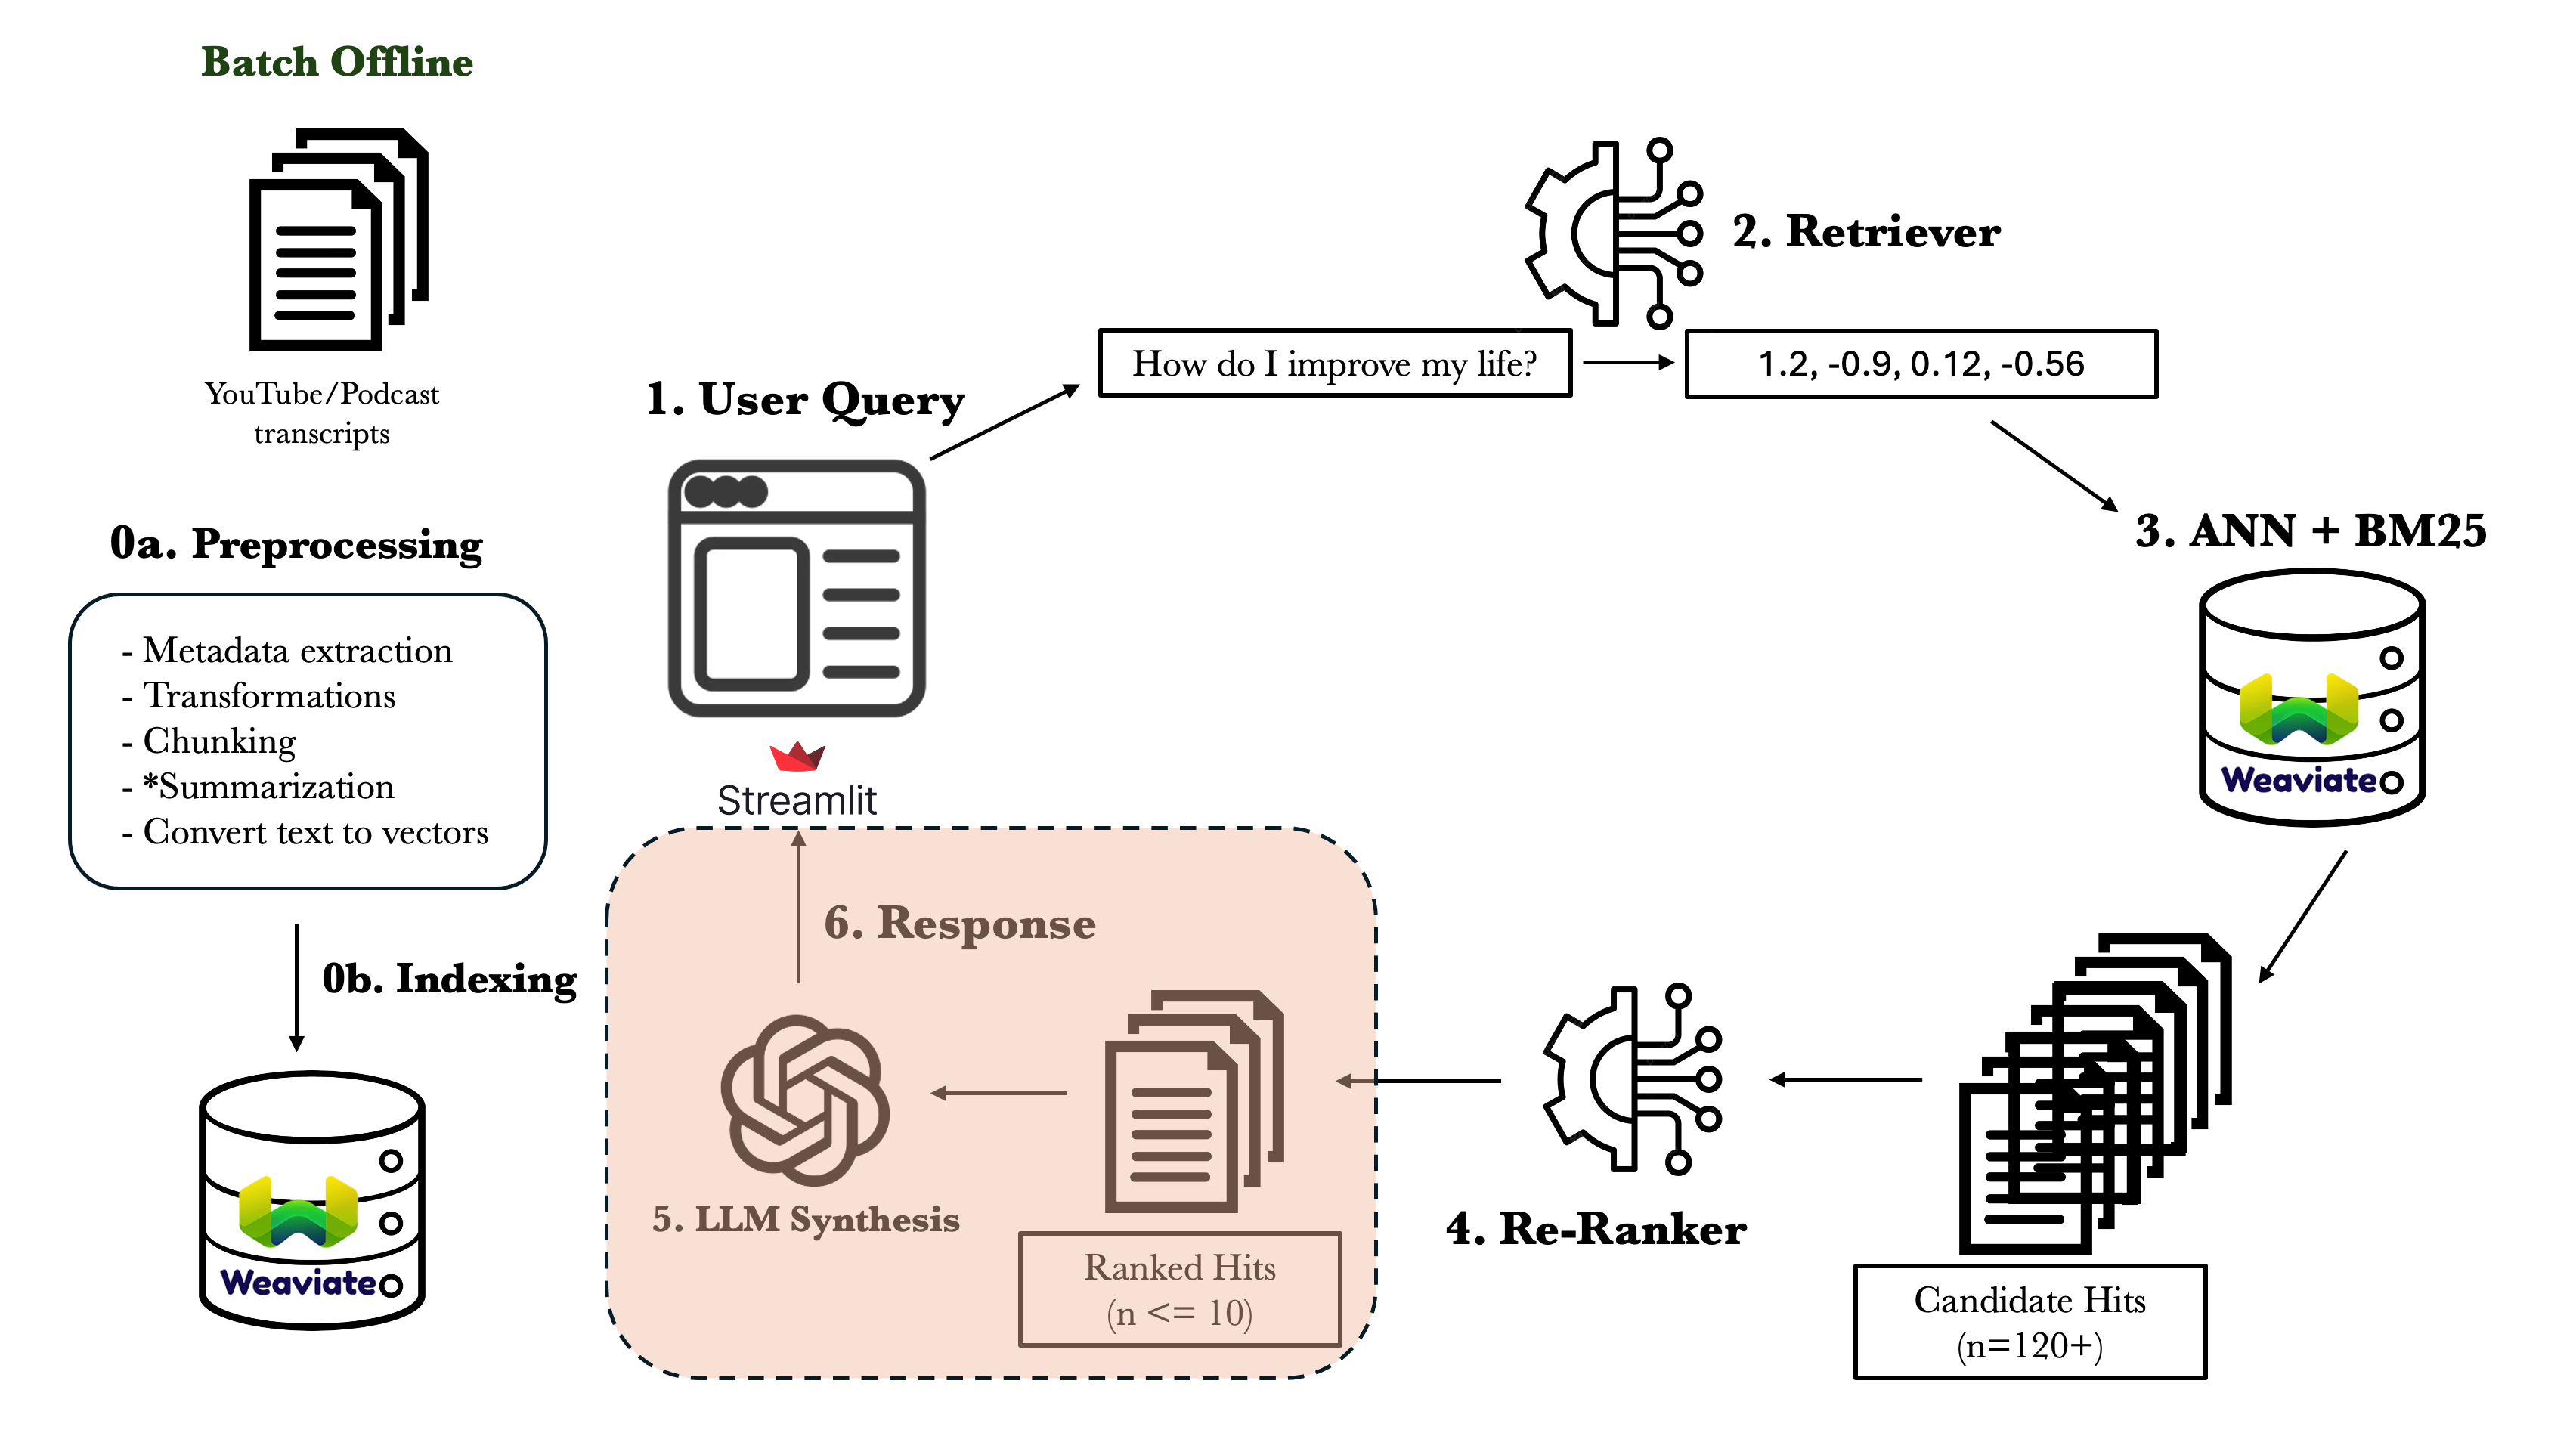)

### Notebook Highlights
In this notebook we'll cover the following topics:
1. Crafting our RAG system message
2. Crafting our RAG user message
3. Making chat completions using the `litellm` framework
4. Build a `Callable` RAG pipeline
5. Introduction to the `DeepEval` LLM evaluation framework
6. Get a baseline score for our LLM Answer Generation

💥 Let's get STARTED! 💥

In [1]:
import sys
sys.path.append('../')

from dotenv import load_dotenv, find_dotenv
envs = load_dotenv(find_dotenv(), override=True)

from warnings import filterwarnings
filterwarnings('ignore')

from src.database.weaviate_interface_v4 import WeaviateWCS
from src.llm.llm_interface import LLM
from src.llm.llm_utils import get_token_count
from src.llm.prompt_templates import (
    huberman_system_message,
    question_answering_user_message, 
    create_context_blocks, 
    generate_prompt_series,
    verbosity_options
)
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric
from src.preprocessor.preprocessing import FileIO
from src.reranker import ReRanker

from deepeval.test_case import LLMTestCase

from tqdm import tqdm
from typing import Literal
from rich import print
import os

/usr/local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/site-packages/pydantic/_internal/_config.py:291: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
/usr/local/lib/python3.10/site-packages/deepeval/__init__.py:53: UserWarning: You are using deepeval version 1.5.2, however version 2.0.5 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:312: PydanticDeprecatedSi

### Set Constants

In [2]:
retriever = WeaviateWCS(os.environ['WEAVIATE_ENDPOINT'], os.environ['WEAVIATE_API_KEY'], skip_init_checks=True)
reranker = ReRanker()
collections = retriever.show_all_collections()

In [3]:
#define collection_name
print(collections)
collection_name = 'Huberman_minilm_256'

['Huberman_minilm_finetuned_256', 'Huberman_minilm_128', 'Huberman_minilm_512', 'Huberman_minilm_256']

In [4]:
#use question bank from previous notebook
queries = ['How to fight age-related muscle loss', 
           'How can listeners support the Huberman Lab podcast', 
           'What is the role of the mid-singulate cortex in the human brain', 
           'Why is sleep so important to maximizing healthspan']

#### Gather initial reranked responses for our queries.  We'll use these later in the notebook

In [5]:
%%time
#1st-Stage Retrieval: Deep search over 200 documents
responses = [retriever.hybrid_search(q, collection_name, alpha=0.25, limit=20) for q in queries] # Setting to 20 to be faster

#2nd-Stage Reranking: keeping only top-3 results
reranked = [reranker.rerank(resp, queries[i], top_k=3) for i,resp in enumerate(responses)]

CPU times: user 8.27 s, sys: 1.38 s, total: 9.65 s
Wall time: 10.5 s


## Discussion
***

Alright, the stage is now set, we have obtained our reranked results and now we are ready to feed them into our LLM for synthesis.  We've completed the **Retrieval** part of RAG, now it's time to Augment the Generation of an answer using those results...but how exactly?

As we've already discussed, effective RAG depends heavily on the quality of the retrieved material.  Hopefully, by now as you've worked through Notebooks 3 and 4, you feel confident that you've built a top-notch system, one that can deliver the best possible results given the corpus you have to work with.  What's left to do now, is feed those results into the LLM as context so the model can perform its job of answer synthesis, this task is primarily accomplished through **prompt engineering**.  

*** *Side note: I try to stay consistent by using the word "message" for describing LLM input, however, throughout this notebook/course I will refer to both "messages" and "prompts" synonymously.* 

### System Message
***
The system message serves as a directive to the model, providing guidance on how to interpret and respond to subsequent user inputs. If crafted well, the system message not only sets the tone for the interaction but also influences the nature and quality of the model's responses. Therefore, it's essential to ensure that the system message is explicit, detailed, and comprehensive. By providing clear instructions and context, end users can more readily expect that the model will produce the desired outcomes. If you look at the [`src/llm/prompt_templates.py`](https://github.com/americanthinker/rag-applications/blob/main/src/llm/prompt_templates.py) file, you'll see a series of pre-defined message templates for this course.  The primary `system_message` that we'll be using is the `huberman_system_message`:

```
1. You are a repository of knowledge and wisdom about the Huberman Lab podcast.
2. The Huberman Lab podcast is hosted by Dr. Andrew Huberman, a neuroscientist and tenured professor of neurobiology 
   and ophthalmology at Stanford School of Medicine. The podcast discusses neuroscience and science-based tools, 
   including how our brain and its connections with the organs of our body control our perceptions, our behaviors, 
   and our health, as well as existing and emerging tools for measuring and changing how our nervous system works. 
   The podcast is frequently ranked in the top 10 of all podcasts globally and is often ranked #1 in the categories 
   of Science, Education, and Health & Fitness.
3. Your task is to answer questions about the Huberman Lab podcast only using the context provided in the user message.
4. Only use the context provided to answer the question. Do not use any external knowledge or resources to answer the question.
```

The **numbers you see above are not part of the actual prompt**, but I've included them here to act as a guide for this discussion:
1. We are explicitly telling the model what it's primary goal or purpose in life is.
2. We provide the model with some background information about the podcast that will be present with every API call.
3. We eplicitly tell the model what it's primary task will be (this will be repeated again in the user message).
4. Because we are building a RAG system, and presumably don't want the model to generate answers based on what it already *thinks* it knows, we are instructing the LLM to stick to the material presented (to the extent that it will listen 😼).

In [6]:
#to see the actual prompt without numbers
print(huberman_system_message)

You are a repository of knowledge and wisdom about the Huberman Lab podcast.
The Huberman Lab podcast is hosted by Dr. Andrew Huberman, a neuroscientist and tenured professor of neurobiology 
and ophthalmology at Stanford School of Medicine. The podcast discusses neuroscience and science-based tools, 
including how our brain and its connections with the organs of our body control our perceptions, our behaviors, 
and our health, as well as existing and emerging tools for measuring and changing how our nervous system works. 
The podcast is frequently ranked in the top 10 of all podcasts globally and is often ranked #1 in the categories 
of Science, Education, and Health & Fitness.
Your task is to answer questions about the Huberman Lab podcast only using the context provided in the user 
message.
Only use the context provided to answer the question. Do not use any external knowledge or resources to answer the 
question.

### User Message
***
Here's where it gets interesting...The user message is the focal point of RAG.  It's the entrypoint for feeding our retrieved context (which we worked so hard to curate), into the LLM for consumption.  To enable this context feeding, I've created a user prompt: `question_answering_user_message` and a helper prompt generation function that will take a series of retrieved results and format them properly.  Let's take a look:

```
- 1. Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his 
guest(s).  After your synthesis, use the series of transcripts to answer the below question.  The series will be in the 
following format:

- 2. 
-----------------------
Show Summary: <summary>
Show Guest: <guest> 
Transcript: <transcript>
------------------------

- 3. 
Start Series:
------------------------
{series}
------------------------

- 4. 
Question:

{question}

------------------------
- 5.  Answer the question and provide reasoning if necessary to explain the answer.

    1. If the context does not provide enough information to answer the question, then
    state that you cannot answer the question with the provided context.
    2. Do not use any external knowledge or resources to answer the question.
    3. Answer the question directly and {verbosity}.

------------------------
Answer:
```

Again the numbering above is not part of the actual prompt. 
1. We reiterate to the model what it's primary task is and we tell it what to expect given the format of the context.
2. We use a one-shot example of what the series of contexts will look like i.e. Summary, Guest, followed by Transcript chunk.
3. The **series** of context blocks (i.e. our retrieved results) is inserted here. Because we have useful metadata (such as `summary` and `guest`) it makes sense to feed that to the LLM as well for additional context, outside of just the transcript chunk (`content` field).
4. The original query is inserted here as the **question**: this is the end user information need.
5. We follow up with explicit directions on what to do after the LLM has reasoned through the text and reiterate not to use external knowledge (i.e. model weights). We also add a **verbosity** option which effectively controls the length of the model output (which can be adjusted based on our use case).

In [7]:
#print to see the prompt without numbers
print(question_answering_user_message)

Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his 
guest(s).
After your synthesis, use the series of transcripts to answer the below question.  The series will be in the 
following format:

```
Show Summary: <summary>
Show Guest: <guest>
Transcript: <transcript>
```

Start Series:
```
{series}
```
Question:

{question}

------------------------
1. If the context does not provide enough information to answer the question, then
state that you cannot answer the question with the provided context.
2. Do not use any external knowledge or resources to answer the question.
3. Answer the question directly and {verbosity}.
------------------------
Answer:

### Assistance Function: Generate a Series for User Prompt
***
The heavy lifting of context insertion and formatting is completed by the [`generate_prompt_series`](https://github.com/americanthinker/rag-applications/blob/main/src/llm/prompt_templates.py#L70) function.  This function insert a results (context) block from the `reranked` variable into the `context_block` string, which is populated by the `create_context_blocks` fucntion.  These blocks are then joined as a series in the prompt generation function. Code examples below show how this is achieved.  When you print out the final result in this example you should see three separate "context blocks" that make up the series. Verbosity options are provided as a natural language means of controlling model output length. 

```
verbosity_options = ['concisely', 'use about four sentences', 'with as much detail as possible, within the limits of the context']

context_block = '''
Show Summary: {summary}
Show Guest: {guest}
Transcript: {transcript}
------------------------
'''
```
```
def create_context_blocks(results: list[dict],
                          summary_key: str='summary',
                          guest_key: str='guest',
                          content_key: str='content'
                          ) -> list[str]:
    ...
    context_series = [context_block.format(summary=res[summary_key],
                                           guest=res[guest_key],
                                           transcript=res[content_key]) 
                      for res in results]
    return context_series
```

```
def generate_prompt_series(query: str, 
                           results: list[dict], 
                           verbosity_level: Literal[0, 1, 2]=0,
                           summary_key: str='summary',
                           guest_key: str='guest',
                           content_key: str='content'
                           ) -> str:
    ...
    verbosity_levels = [0, 1, 2]
    if not isinstance(verbosity_level, int) or verbosity_level not in verbosity_levels:
        raise ValueError(f'verbosity_level must be an integer: {verbosity_levels}')
    verbosity = verbosity_options[verbosity_level]
    context_series = f'\n'.join(create_context_blocks(results, summary_key, guest_key, content_key)).strip()
    prompt = question_answering_user_message.format(question=query, series=context_series, verbosity=verbosity)
    return prompt
```

In [78]:
user_prompt = generate_prompt_series(queries[0], reranked[0], verbosity_level=0)
print(user_prompt)

Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his 
guest(s).
After your synthesis, use the series of transcripts to answer the below question.  The series will be in the 
following format:

```
Show Summary: <summary>
Show Guest: <guest>
Transcript: <transcript>
```

Start Series:
```
Show Summary: In the Huberman Lab guest series episode with Dr. Andy Galpin, they discuss the science and methods 
to increase strength, hypertrophy (muscle growth), and endurance. Dr. Galpin highlights the importance of strength 
and hypertrophy training for everyone, not just athletes, as it combats neuromuscular aging and preserves muscle 
function. He clarifies that strength training is essential for maintaining muscle power and strength, which is 
crucial for everyday movements and preventing falls as we age. The conversation also touches on the benefits of 
strength and hypertrophy training for cognitive function, immune health, and overall longevity. Dr. Galpin dispels 
misconceptions about strength training, emphasizing that it can be started at any age and is not solely for 
building muscle mass, but also for maintaining functional abilities. He also discusses the neuromuscular 
adaptations that occur with strength training, such as improved nerve firing, muscle contractility, and changes in 
muscle fiber type.
Show Guest: Dr. Andy Galpin
Transcript: In general, human movement is a function of, number one, some sort of neuromuscular activation. So 
nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to 
move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in 
human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to 
do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train.
So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's 
true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of 
strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year.
------------------------


Show Summary: The episode "Science of Muscle Growth, Increasing Strength & Muscular Recovery" with Andrew Huberman 
delves into the mechanisms and best practices for muscle development, strength enhancement, and recovery. Huberman 
explains that muscle growth, or hypertrophy, and strength gains are not solely dependent on heavy weights but can 
be achieved through a range of resistance exercises at 30-80% of one's maximum capacity, with the key being to 
perform enough sets to near failure each week. He emphasizes the importance of the nervous system in directing 
muscle movement and growth, highlighting the Henneman size principle, which states that muscles recruit motor units
from low to high threshold to conserve energy. Huberman also discusses the benefits of resistance training for 
hormonal responses, such as increasing testosterone, and the impact of lactate as a hormonal signal that can 
improve brain, heart, and liver function when exercising at high intensity. The episode underscores the importance 
of tailored resistance training for individual goals, whether for muscle size, strength, speed, or
Show Guest: Andrew Huberman
Transcript: But I think the research shows now that everyone of pretty much every age should be doing some sort of 
resistance exercise, even if that's body weight exercises in order to offset this age-related decline in muscle 
contractile ability, muscle strength, et cetera, improve bone density. There's nothing good about getting frail and
weak over time. And people who invest the effort into doing resistance exercise of some kind, whether or not it's 
with bands or with weights or with

### Token Count
***
To get a sense of the number of input tokens we are using between the system and user messages we can use our [`get_token_count`](https://github.com/americanthinker/rag-applications/blob/main/src/llm/llm_utils.py#L6) utility function. Generally speaking the token count will roughly be the same +/- 100 tokens from one set of search results to the next, assuming you are using the same collection with a set chunk_size.  You should see a big difference however if you switch from one `chunk_size` to another, include more than 3 results in your context series, or switch the `verbosity` levels. 

In [80]:
total_tokens = get_token_count([huberman_system_message, user_prompt])
print(total_tokens)

1635

## Putting it all together: Using the `litellm` library
--- 
As a reminder, for this course we are using the `litellm` interface which allows users to swap out different models from different providers, while maintaining the same functionality and model output format.  The choice was made to use this framework to allow students to use the LLM of their choice, and have the codebase work for them out of the box.  That said, you are free to call the LLM API of your choice directly and write Classes/methods to enable that functionality. I know it's sometimes hard to remember the specific model version, so I've included a convenient way of displaying all of the valid models supported out of the box (for this course) in the `LLM` class itself:

In [10]:
print(LLM.valid_models)

{
    'openai': ['gpt-4o', 'gpt-4o-mini'],
    'anthropic': ['claude-3-sonnet-20240229', 'claude-3-haiku-20240307'],
    'cohere': ['command-r', 'command-r-plus']
}

Let's see the system in action integrated with the LLM.  For this demo, I'm going to use `gpt-4o-mini`.  It's fast, cheap, and (for the most part) reliable. 

In [11]:
#instantiate the LLM Class
mini = 'gpt-4o-mini'
#the LLM Class will use the OPENAI_API_KEY env var as the default api_key 
llm = LLM(mini)

We'll use the queries and the returned results from our original queries earlier in the notebook, and plug them into a simple llm call.  
Reviewing a snapshot of the `chat_completion` method, you'll note that all of the standard Generative LLM params are availble, and if not, can always be passed in as a keyword argument (kwarg).  Depending upon the desired response, this method will return either a string, a `CustomStreamWrapper` which can be iterated over to show a streaming response, or a litellm `ModelResponse` which is very similar to standard Generative LLM output Classes. 

```
def chat_completion(self, 
                    system_message: str,
                    user_message: str,
                    temperature: int=0, 
                    max_tokens: int=500,
                    stream: bool=False,
                    raw_response: bool=False,
                    **kwargs
                    ) -> str | CustomStreamWrapper | ModelResponse:
        ...
```

***
**Assuming you have the `queries` and `reranked` variables defined earlier in the notebook:**
1. Change the value of `i` below to make calls to the LLM using different `user_prompts`.
2. Take the time to also change the verbosity level from 0-2 and notice how both the length of the output expands as well as the call latency. 
3. `litellm` has a convenient `completion_cost` method that you can run to check the cost of each call made.  Take note of the cost difference between verbosity levels 0 and 2, use the code in the **Completion Cost function** section below.

In [81]:
from litellm import completion_cost

i = 0
#create new user prompt for each i value
user_prompt = generate_prompt_series(queries[i], reranked[i], verbosity_level=0)

response = llm.chat_completion(system_message=huberman_system_message,
                               user_message=user_prompt,
                               temperature=0.5,
                               stream=False,
                               raw_response=False)
print(response)

I cannot answer the question with the provided context.

### Completion Cost function

Run the below cell to check the cost of any call in US dollars ($).  The creators of `litellm` did a fantastic job of making the `completion_cost` function very flexibility.  There are several ways to interact with this function, but generally speaking the more information you can provide, the more accurate the cost calculation will be.

In [13]:
completion_cost(model=llm.model_name, 
                prompt=huberman_system_message+' '+user_prompt, 
                completion=response, 
                call_type='completion')

0.0003273

# Assignment 2.3 - RAG Pipeline 
***
#### *Construct a basic RAG pipeline using the components that you have already imported into this notebook.*
#### INSTRUCTIONS

1. Complete the `RAGPipeline` Class `__call__` method by filling in code wherever you see **None**.
   - This assignment will give you a feel for how well you understand each component of the RAG cycle.
   - It will prepare you for plugging in these components into your final Streamlit app.
   - If this is your first time constructing a `__call__` method, it's just a python convention for creating a [special method that allows an instance of a class to be called as if it were a function](https://medium.com/@johnidouglasmarangon/using-call-method-to-invoke-class-instance-as-a-function-f61396145567).
2. Once you have a working pipeline, query the Huberman Lab podcast using the topics below as a guide and change the parameters to see how they affect the model response.  Pay particular attention to changing the `verbosity` and `temperature` params.  You could also adjust `top_k` and feed additional context to the LLM, note how the model's response changes (or doesn't change) with the additional context. Switch `raw_response` to `True` to get a view of the raw model response. 
3. Try incorporating the `completion_cost` function to see how much each call will cost.

4. See below for sample topics to learn about:
    1. **Nutrition & Diet:**
       - "Dr. Layne Norton: The Science of Eating for Health, Fat Loss & Lean Muscle"
       - "How Foods and Nutrients Control Our Moods"
    
    2. **Exercise & Fitness:**
       - "Dr. Duncan French: How to Exercise for Strength Gains & Hormone Optimization"
       - "Fitness Toolkit: Protocol & Tools to Optimize Physical Health"
    
    3. **Learning & Memory Enhancement:**
       - "Science-Based Mental Training & Visualization for Improved Learning"
       - "Understanding and Using Dreams to Learn and to Forget"
    
    4. **Cognitive Performance & Focus Improvement:**
       - "Focus Toolkit: Tools to Improve Your Focus & Concentration"
       - "How to Focus to Change Your Brain"
    
    5. **Personal Development & Goal Setting:**
        - "Tim Ferriss: How to Learn Better & Create Your Best Future"
        - "Goals Toolkit: How to Set & Achieve Your Goals"

In [15]:
from src.llm.prompt_templates import (
    huberman_system_message,
    question_answering_user_message, 
    create_context_blocks, 
    generate_prompt_series,
    verbosity_options
)

class RAGPipeline:
    '''
    Basic RAG pipeline for answer generation.
    '''
    def __init__(self, 
                 retriever: WeaviateWCS,
                 reader_llm: LLM, 
                 collection_name: str,
                 reranker: ReRanker=None,
                 top_k: int = 3,
                 temperature: float = 0.5,
                 verbosity: Literal[0,1,2]=0,
                 system_message: str=huberman_system_message,
                 base_user_message: str=question_answering_user_message
                 ):
        
        #info that will be available for each class instance
        self.retriever = retriever
        self.collection_name = collection_name
        self.reranker = reranker
        self.system_message = system_message
        self.base_user_message = base_user_message
        self.llm = reader_llm
        self.top_k = top_k
        self.temperature = temperature
        self.verbosity = verbosity

        # this configuration will be used later in the LLM Evaluation section
        self.generation_config = {'reader_model': reader_llm.model_name,
                                  'temperature' : self.temperature,
                                  'verbosity': verbosity_options[self.verbosity],
                                  'num_context_chunks': self.top_k,
                                  'system_message' : self.system_message,
                                  'user_message' : self.base_user_message}
        
    #################
    ##  START CODE ##
    #################
    
    def __call__(self,
                 query: str,
                 alpha: float=0.25,
                 limit: int=20,
                 raw_response: bool=False,
                 **llm_kwargs
                 ) -> dict[str, str | list[str]]:
        '''
        Triggers retrieval, reranking, and LLM call. Returns LLM response.
        '''        
        # implement your hybrid search call 
        search_results = self.retriever.hybrid_search(query, self.collection_name, alpha=alpha, limit=limit)

        #implement your reranking step
        if self.reranker:
            search_results = self.reranker.rerank(search_results, query, top_k=self.top_k)
        else:
            search_results = search_results[:self.top_k]
            
        user_message = generate_prompt_series(query, search_results, verbosity_level=self.verbosity)
        answer = self.llm.chat_completion(system_message=self.system_message,
                                          user_message=user_message,
                                          temperature=self.temperature,
                                          raw_response=raw_response,
                                          **llm_kwargs)
        
        
        retrieval_context = create_context_blocks(search_results)

        #results are returned as a dictionary for later us in the LLM evaluation section
        return {'input': query, 'retrieval_context': retrieval_context, 'actual_output': answer}

In [16]:
#instantiate your RAGPipeline Class

pipe = RAGPipeline(retriever=retriever,
                   reader_llm=llm,
                   collection_name=collection_name,
                   reranker=reranker,
                   system_message=huberman_system_message)

    #################
    ##  END CODE   ##
    #################

### Test Functionality

In [17]:
llm_response = pipe('How to fight age-related muscle loss')
print(llm_response['actual_output'])

To fight age-related muscle loss, it is essential to engage in strength training. This can include resistance 
exercises at various intensities, such as body weight exercises, weights, or bands. It is recommended to perform 
dedicated strength training to offset the age-related decline in strength, which can be around 3-5% per year after 
age 40. Incorporating a structured fitness regimen that includes both resistance training and cardiovascular 
workouts, along with adequate recovery and nutrition, can help maintain or even build strength as one ages.

Expected Output to the **"How to fight age-related muscle loss?"** query, something similar to:
```
To fight age-related muscle loss, it is recommended to engage in strength training to preserve 
muscle power and strength, combat neuromuscular aging, and maintain functional abilities. This can help offset the natural decline in muscle mass and strength that occurs with aging.
```

# So Now What? --> LLM Evaluation
### Discussion
***

At this point in the RAG system we should feel confident about the following:  
**1. We know we have a solid retrieval system, because we've objectively measured it's performance** ✅  
**2. We have a range of tools that we can apply to our retrieval system to make it even better**  ✅

We're in a good spot, but how do we know if the model is correctly answering the user inputs, based on the retrieved context?  The returned responses sound plausible, right....  
I think we would all agree that adding a third item to our RAG system checklist would put us in a more secure position to support the claim that our system is working as expected:  

**3. We know that the LLM is effectively answering the user input based on the retrieved context**   ❌
   
To address point 3 we need a way to evaluate the model's responses in an obejctive fashion, so that we can get a baseline benchmark (just like we did with retrieval) and then compare scores across time as we make adjustments to the system. 

### Manual Solution
---
One way to address point 3 is to manually evaluate the LLM responses, compare the answers to the retrieved context, and then assign a subjective score based on our judgement of how correct the answers is. Let's take a look at how we would do this in practice. 
1. We'll reuse our output from the `pipe` testing.
2. Print out all three pieces of information (query, retrieved context, answer) and perform an evaluation.
3. Assign a score between 0 and 1, with 1 being 100% correct (based on the context) and 0 being completely wrong.
4. Don't spend more than 5 minutes on this assignment. 

In [18]:
#rerun again if necessary
# llm_response = pipe("How to fight age-related muscle loss")

#unpack data values
query, context, answer = [v for v in llm_response.values()]

In [19]:
print('*'*100)
print(f'USER INPUT:\t{query}\n')
print('*'*100)
for i, c in enumerate(context, 1):
    print(f'RETRIEVED CONTEXT BLOCK {i}:')
    print(f'{context[i-1]}\n\n')
print('*'*100)
print(f'MODEL RESPONSE: {answer}')

****************************************************************************************************

USER INPUT:     How to fight age-related muscle loss

****************************************************************************************************

RETRIEVED CONTEXT BLOCK 1:

Show Summary: In the Huberman Lab guest series episode with Dr. Andy Galpin, they discuss the science and methods 
to increase strength, hypertrophy (muscle growth), and endurance. Dr. Galpin highlights the importance of strength 
and hypertrophy training for everyone, not just athletes, as it combats neuromuscular aging and preserves muscle 
function. He clarifies that strength training is essential for maintaining muscle power and strength, which is 
crucial for everyday movements and preventing falls as we age. The conversation also touches on the benefits of 
strength and hypertrophy training for cognitive function, immune health, and overall longevity. Dr. Galpin dispels 
misconceptions about strength training, emphasizing that it can be started at any age and is not solely for 
building muscle mass, but also for maintaining functional abilities. He also discusses the neuromuscular 
adaptations that occur with strength training, such as improved nerve firing, muscle contractility, and changes in 
muscle fiber type.
Show Guest: Dr. Andy Galpin
Transcript: In general, human movement is a function of, number one, some sort of neuromuscular activation. So 
nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to 
move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in 
human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to 
do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train.
So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's 
true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of 
strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year.
------------------------

RETRIEVED CONTEXT BLOCK 2:

Show Summary: The episode "Science of Muscle Growth, Increasing Strength & Muscular Recovery" with Andrew Huberman 
delves into the mechanisms and best practices for muscle development, strength enhancement, and recovery. Huberman 
explains that muscle growth, or hypertrophy, and strength gains are not solely dependent on heavy weights but can 
be achieved through a range of resistance exercises at 30-80% of one's maximum capacity, with the key being to 
perform enough sets to near failure each week. He emphasizes the importance of the nervous system in directing 
muscle movement and growth, highlighting the Henneman size principle, which states that muscles recruit motor units
from low to high threshold to conserve energy. Huberman also discusses the benefits of resistance training for 
hormonal responses, such as increasing testosterone, and the impact of lactate as a hormonal signal that can 
improve brain, heart, and liver function when exercising at high intensity. The episode underscores the importance 
of tailored resistance training for individual goals, whether for muscle size, strength, speed, or
Show Guest: Andrew Huberman
Transcript: But I think the research shows now that everyone of pretty much every age should be doing some sort of 
resistance exercise, even if that's body weight exercises in order to offset this age-related decline in muscle 
contractile ability, muscle strength, et cetera, improve bone density. There's nothing good about getting frail and
weak over time. And people who invest the effort into doing resistance exercise of some kind, whether or not it's 
with bands or with weights or with body weight, really benefit tremendously at a whole body level, at a systemic 
level, as well as in terms of muscle strength. There is a good predictor of how well or how efficient you will be 
in building the strength and or if you like the size of a given muscle. And it has everything to do with those 
upper motor neurons that are involved in deliberate control of muscle. You can actually do this test right now. You
can just kind of march across your body mentally and see whether or not you can independently contract any or all 
of your muscles.
------------------------

RETRIEVED CONTEXT BLOCK 3:

Show Summary: In the Huberman Lab podcast episode titled "Science-Supported Tools to Accelerate Your Fitness 
Goals," host Dr. Andrew Huberman and guest Dr. Andy Galpin discuss science-based strategies for enhancing fitness 
routines. The episode covers a wide range of protocols including how to structure a fitness regimen and integrate 
recovery, nutrition, and supplementary measures to augment strength, hypertrophy, endurance, anaerobic capacity, 
and more. Huberman highlights select protocols he has incorporated into his routine that are fun and time-efficient
and encourages listeners to tailor these strategies to their goals without significantly increasing workout 
duration.

Key components of any fitness program consist of a combination of cardiovascular and resistance training sessions. 
The episode emphasizes the necessity of including different training types (like zone two cardio, strength 
sessions, and different cardiovascular workouts) and recovery to make continuous progress.

Specific tools discussed include "meshing" zone two cardio with daily activities, like walking, to hit the 
recommended 200 minutes per week without additional scheduling.
Show Guest: Dr. Andy Galpin
Transcript: That's also because we know that maintaining or improving strength of our muscles is very important 
across the entire lifespan, but especially in the years spanning from 40 until death, which I think for most people
fall somewhere between 50, 60, 70, or ideally out into the 80s, 90s, or hundreds, right? That's what we're all 
seeking is to die later in better health. And in order to do that, we have to dedicate some very specific training 
protocols in order to maintain or build strength. So to summarize, in addition to all the positive reasons to do 
dedicated strength training that I mentioned before, it's highly recommended that you do some dedicated strength 
training for the purposes of offsetting the age-related decline in strength that occurs. Again, three to 5% per 
year past age 40, which is a pretty significant decline. But the good news is if you do the three to five protocol 
for say 12 weeks per year, and then you continue to resistance train using other repetition ranges geared towards 
hypertrophy and strength, or perhaps even muscular endurance. The good news is you'll maintain your strength and 
perhaps even build your strength, offsetting that natural decrease that would otherwise occur.
------------------------

****************************************************************************************************

MODEL RESPONSE: To fight age-related muscle loss, it is essential to engage in strength training. This can include 
resistance exercises at various intensities, such as body weight exercises, weights, or bands. It is recommended to
perform dedicated strength training to offset the age-related decline in strength, which can be around 3-5% per 
year after age 40. Incorporating a structured fitness regimen that includes both resistance training and 
cardiovascular workouts, along with adequate recovery and nutrition, can help maintain or even build strength as 
one ages.

<details>
  <summary><strong>Click here once you've made your evaluation.</strong></summary>
  
I pulled the following statements out of the context that support the answer:   


* "...the only way to preserve that or fight that loss of aging is to strength train."
* "...it's highly recommended that you do some dedicated strength training for the purposes of offsetting the age-related decline in strength that occurs."
* "But the good news is if you do the three to five protocol for say 12 weeks per year, and then you continue to resistance train using other repetition ranges geared towards hypertrophy and strength, or perhaps even muscular endurance. The good news is you'll maintain your strength and perhaps even build your strength, offsetting that natural decrease that would otherwise occur."

Based on these statements from the context and the response from the LLM I would assign a score of:  
<code><span style='color:blue'>1.0, because the model correctly answered the question and did not contradict anything from the context.</span>
</code>
<br></br>
**Welcome to the world of LLM Evaluations, the alignment between human evaluation and LLM evaluations is an important concept in the Information Retrieval field right now. This is a small taste of a manual evaluation that we'll be automating using DeepEval in the notebook examples below.**

</details>
<br>

### Automated Solution
---
Ok, I hope you completed the above exercise to get a taste of the type of work that we'll be automating using [DeepEval framework](https://docs.confident-ai.com/docs/getting-started).  Let's quickly recap the Evaluation flow:

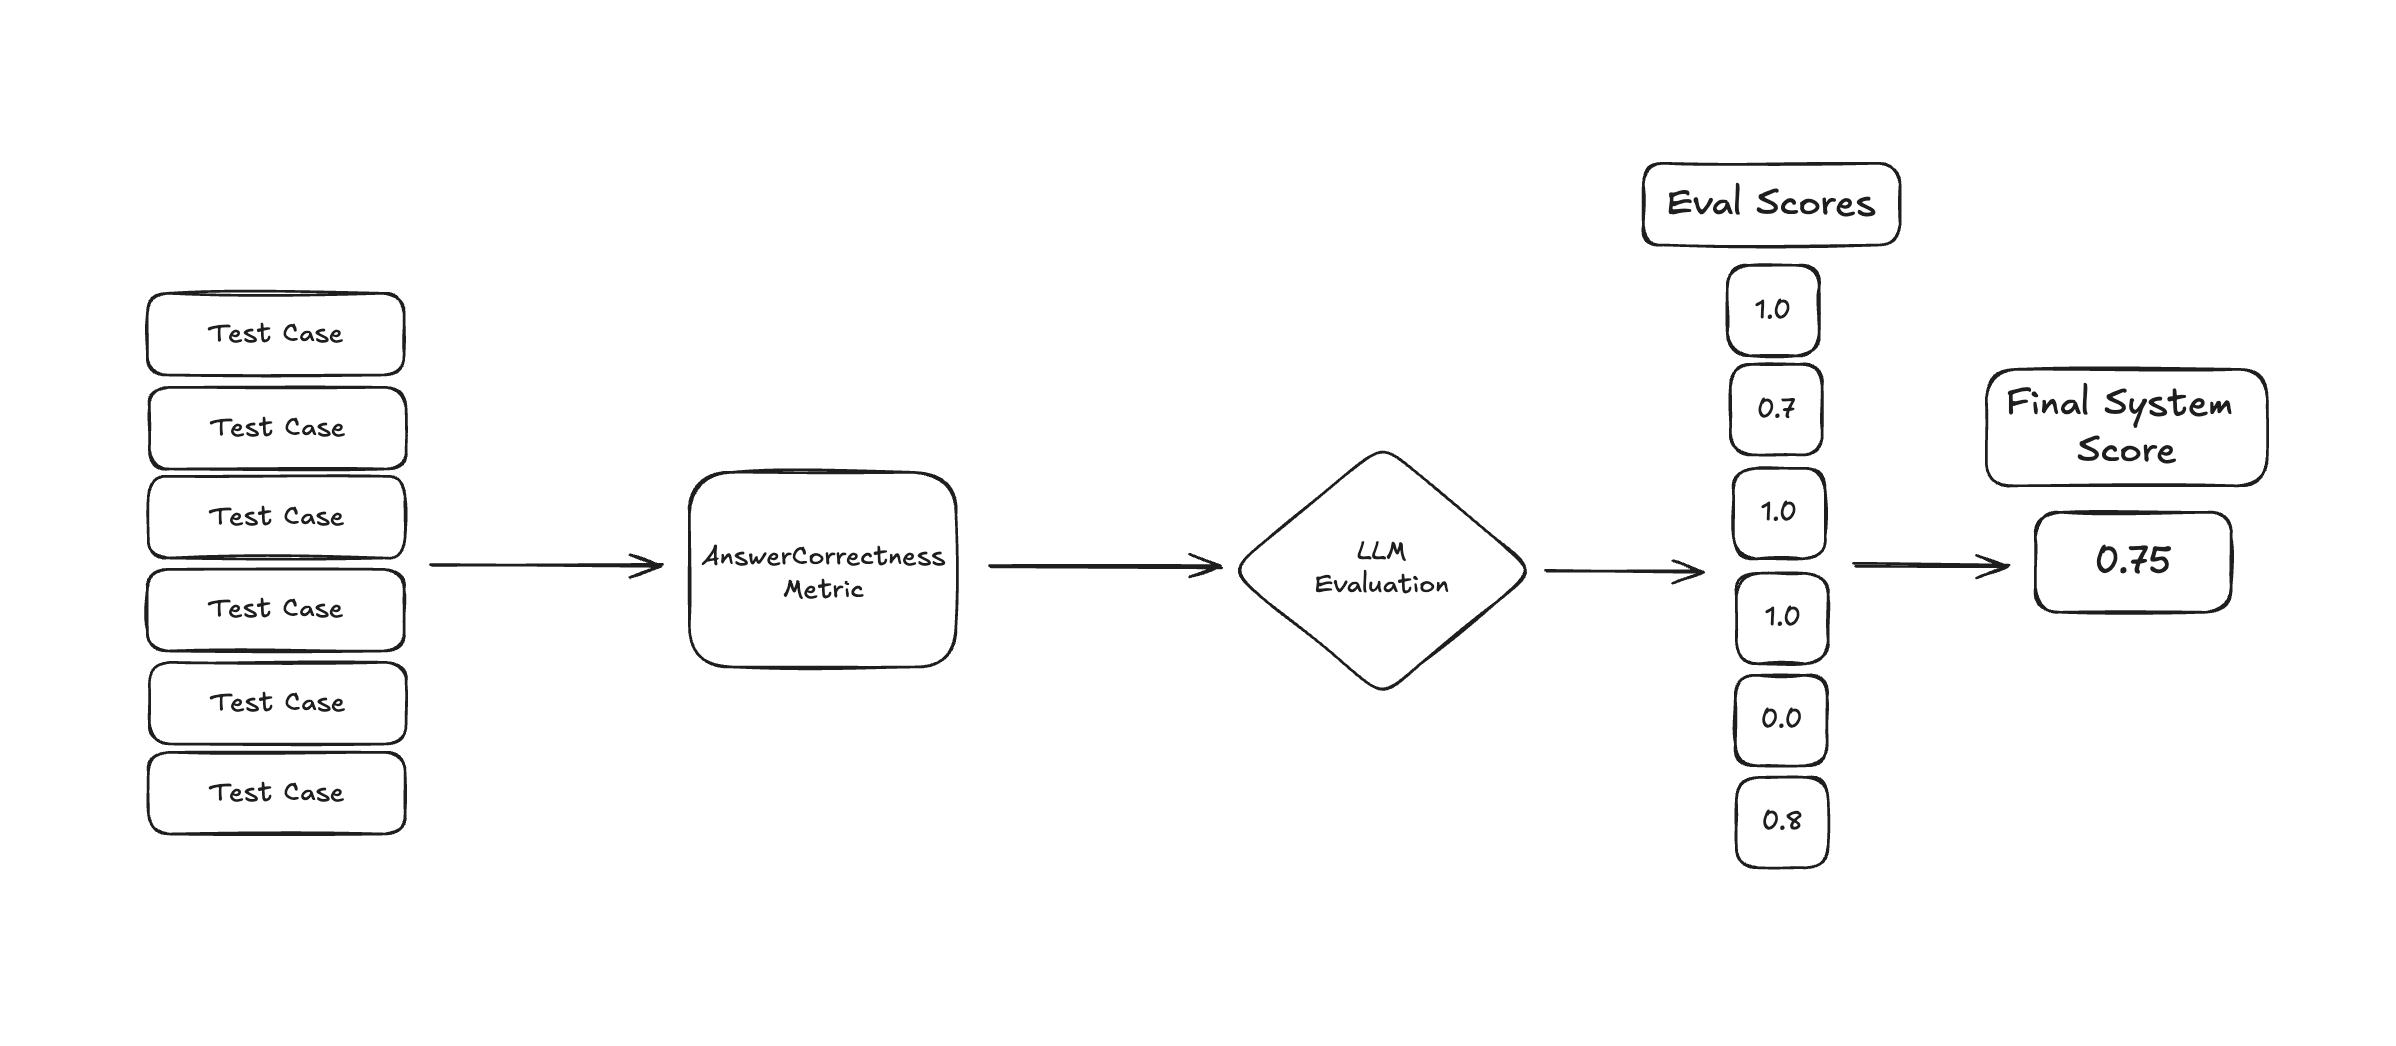

### 1 - Test Cases

Executing an evaluation using DeepEval requires three components: 
1. An evaluation LLM (preferably a higher-end LLM like `gpt-4o`).  **Keep in mind, this is an evaluation LLM, not to be confused with the RAG system Reader model - `gpt-4o-mini`.**
2. An evaluation metric (in this case Answer Correctness)
3. A test case, defined as a `LLMTestCase` Class in DeepEval. A test case is simply an organizational structure for passing in the relevant information that the evalaution LLM needs to measure the metric.  In this case, we will be passing in the `input` (query), the `actual_output` (response from our reader LLM), and the `retrieval_context` (the retrieved context from our search results).
4. The Evaluation LMM will review the input/query and determine if the answer/actual_output from the Reader LLM is correct based on the information found in the retrieval context. 

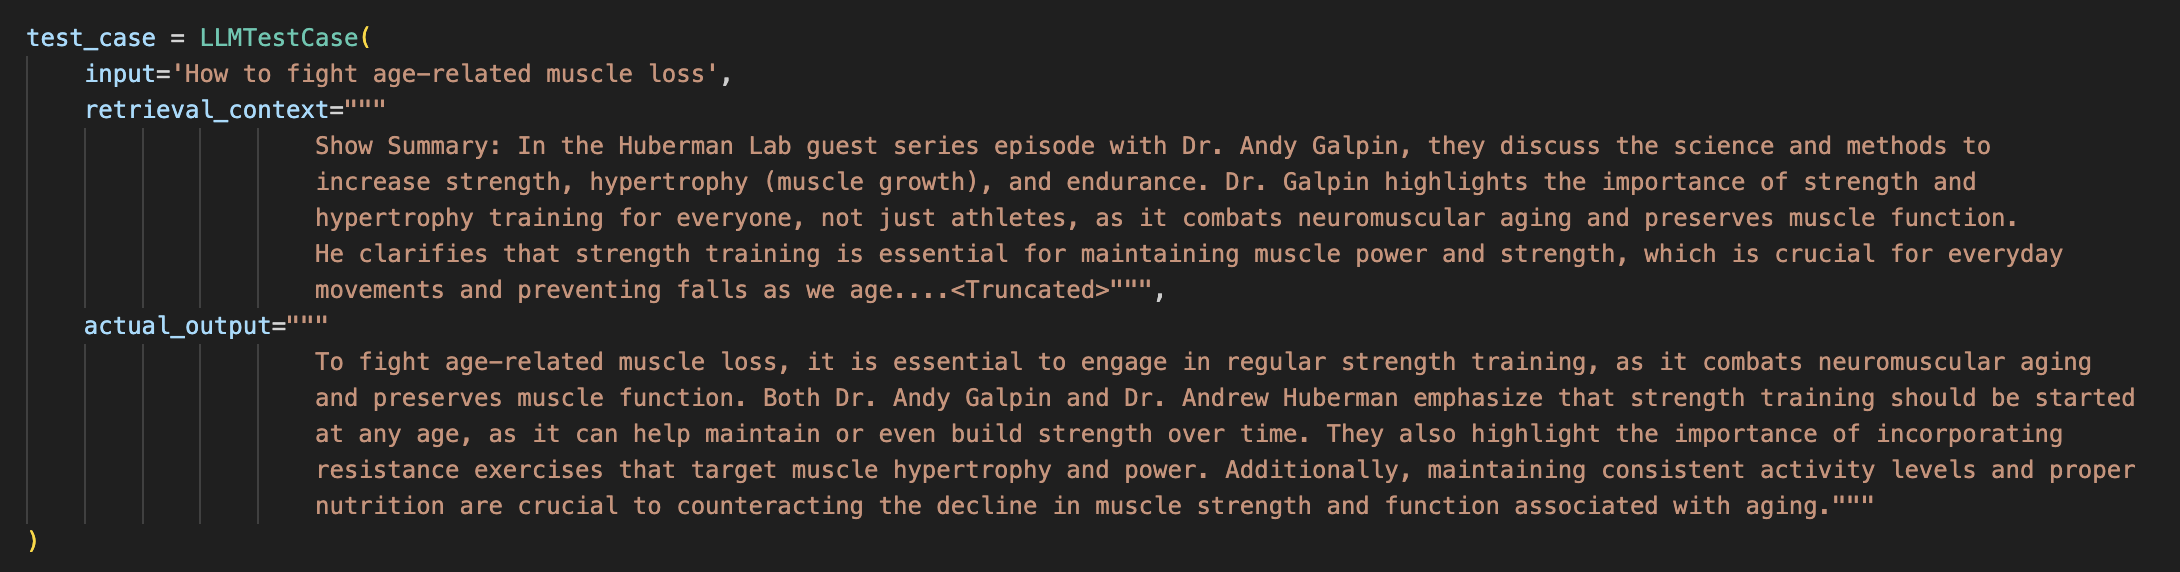

### 2 - Metric: Answer Correctness
As referenced in the Week 2 Course Content (LLM Evaluation sections), before we evaluate anything we have to decide what we are going to measure. There are several LLM evaluation metrics that we can choose from.  However, in my opinion, it's best to start simple, so we'll use the most basic and intuitive metric, `AnswerCorrectness` which addresses the fundamental question of "Did the LLM produce the correct answer (given the context)?".  

#### Evaluation Steps
As a recap, the AnswerCorrectness metric is a prompt fed into an Evaluation LLM that adheres to the following evaluation steps, after receiving the RAG pipeline query, context, and answer/actual_output:
   * Compare the actual output with the retrieval context to verify factual accuracy.
   * Assess if the actual output effectively addresses the specific information requirement stated in the input.
   * Determine the comprehensiveness of the actual output in addressing all key aspects mentioned in the input.
   * If there is not enough information in the retrieval context to correctly answer the input, and the actual output indicates that the input cannot be answered with the provided context, then the score should be 1.

#### Metric Threshold
Though not required, we can pass a threshold float value into the AnswerCorrectness metric, which allows us to set the conditions for what is considered a successful response or not.  As you'll see, determining whether an LLM correctly answered a question or not (particularly a question with multiple components), is not as straightfoward as you might initially think.  Because we are asking the model to score the response with a value between 0 and 1 this implies that there is a **range** of potential outcomes.  `threshold` allows us to draw a line in the sand where values below the threshold are considered incorrect and vice versa.  The default threshold value for AnswerCorrectness is `0.8` but can be adjusted depending on your use case. 


💥 Enough chat, let's see the code.  💥

##### 1. Create a Test Case from the previous query results
**Quick Note**: Because the keys of the `llm_response` are intentionally the same as the parameter names in the `LLMTestCase` Class we can unpack the dictionary directly using the `**` operator. 

In [20]:
from deepeval.test_case import LLMTestCase

#build a Test Case using the previous llm_response
test_case = LLMTestCase(**llm_response)  # <--- Same things as doing this: test_case = LLMTestCase(llm_response["input"], 
                                                                                                #  llm_response["retrieval_context"], 
                                                                                                #  llm_response["acutal_output"])

##### 2. Instantiate a metric by passing in the Evaluation model name (string)

In [21]:
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric

#metric takes in an evaluation LLM of our choice as a string
evaluation_llm = 'gpt-4o-mini'
ac_metric = AnswerCorrectnessMetric(evaluation_llm)

#view the evaluation steps that go into the custom AnswerCorrectness metric
ac_metric.evaluation_steps

['Compare the actual output with the retrieval context to verify factual accuracy.',
 'Assess if the actual output effectively addresses the specific information requirement stated in the input.',
 'Determine the comprehensiveness of the actual output in addressing all key aspects mentioned in the input.',
 'If there is not enough information in the retrieval context to correctly answer the input, and the actual output indicates that the input cannot be answered with the provided context, then return a score of 10.']

<div class="alert alert-danger"><h5>WARNING - Executing the `measure` function will trigger a call to the LLM that you passed into the `AnswerCorrectnessMetric`.  In this case it's only a single LLM call, so the cost will be minimal, but other metrics in the DeepEval library make multiple LLM calls under the hood...</h5></div>  

##### 3. Execute the AnswerCorrectness evaluation by calling the `measure` function


In [22]:
#you will likely see a nest_asyncio patching message
ac_metric.measure(test_case, _show_indicator=False)

Event loop is already running. Applying nest_asyncio patch to allow async execution...


##### 4. View the `metric` object, pay particular attention to:
- `evaluation_cost` - Cost of running the evaluation test
- `reason` - Reasoning behind the score provided by the evaluation LLM
- `score` - The score result from the evaluation test (as determined by the evaluation LLM)

In [23]:
print(f'Cost: ${ac_metric.evaluation_cost:.3f}')
print(f'Reason: {ac_metric.reason}')
print(f'Score: {ac_metric.score:.2f}')

Cost: $0.000

Reason: The actual output accurately emphasizes the importance of strength training to combat age-related muscle 
loss, which aligns with the retrieval context that discusses similar themes around maintaining muscle strength and 
addressing the decline in strength after age 40.

Score: 1.00

In [24]:
# view entire metric object
print(ac_metric.__dict__)

{
    'model': <deepeval.models.gpt_model.GPTModel object at 0x78c78679f4f0>,
    'name': 'AnswerCorrectness',
    'evaluation_params': [
        <LLMTestCaseParams.INPUT: 'input'>,
        <LLMTestCaseParams.ACTUAL_OUTPUT: 'actual_output'>,
        <LLMTestCaseParams.RETRIEVAL_CONTEXT: 'retrieval_context'>
    ],
    'criteria': None,
    'using_native_model': True,
    'evaluation_model': 'gpt-4o-mini',
    'evaluation_steps': [
        'Compare the actual output with the retrieval context to verify factual accuracy.',
        'Assess if the actual output effectively addresses the specific information requirement stated in the 
input.',
        'Determine the comprehensiveness of the actual output in addressing all key aspects mentioned in the 
input.',
        'If there is not enough information in the retrieval context to correctly answer the input, and the actual 
output indicates that the input cannot be answered with the provided context, then return a score of 10.'
    ],
    'threshold': 0.8,
    'strict_mode': False,
    'async_mode': True,
    'verbose_mode': False,
    '_include_g_eval_suffix': True,
    'evaluation_cost': 0.0002916,
    'reason': 'The actual output accurately emphasizes the importance of strength training to combat age-related 
muscle loss, which aligns with the retrieval context that discusses similar themes around maintaining muscle 
strength and addressing the decline in strength after age 40.',
    'score': 1.0,
    'success': True,
    'verbose_logs': 'Criteria:\nNone \n \nEvaluation Steps:\n[\n    "Compare the actual output with the retrieval 
context to verify factual accuracy.",\n    "Assess if the actual output effectively addresses the specific 
information requirement stated in the input.",\n    "Determine the comprehensiveness of the actual output in 
addressing all key aspects mentioned in the input.",\n    "If there is not enough information in the retrieval 
context to correctly answer the input, and the actual output indicates that the input cannot be answered with the 
provided context, then return a score of 10."\n]'
}

##### 5. A better way to view the metric data, to include the contextual data associated with the test case is to use the `load_eval_response` function
- Puts the most important information on the top
- Includes the `input`, `actual_output`, and `retrieval_context` data for reference

In [25]:
from src.evaluation.llm_evaluation import load_eval_response 

eval_response = load_eval_response(ac_metric, test_case, return_context_data=True)
print(eval_response)

EvalResponse(
    score=1.0,
    reason='The actual output accurately emphasizes the importance of strength training to combat age-related 
muscle loss, which aligns with the retrieval context that discusses similar themes around maintaining muscle 
strength and addressing the decline in strength after age 40.',
    metric='AnswerCorrectnessMetric',
    cost=0.0002916,
    eval_model='gpt-4o-mini',
    verdicts=None,
    input='How to fight age-related muscle loss',
    actual_output='To fight age-related muscle loss, it is essential to engage in strength training. This can 
include resistance exercises at various intensities, such as body weight exercises, weights, or bands. It is 
recommended to perform dedicated strength training to offset the age-related decline in strength, which can be 
around 3-5% per year after age 40. Incorporating a structured fitness regimen that includes both resistance 
training and cardiovascular workouts, along with adequate recovery and nutrition, can help maintain or even build 
strength as one ages.',
    retrieval_context=[
        "\nShow Summary: In the Huberman Lab guest series episode with Dr. Andy Galpin, they discuss the science 
and methods to increase strength, hypertrophy (muscle growth), and endurance. Dr. Galpin highlights the importance 
of strength and hypertrophy training for everyone, not just athletes, as it combats neuromuscular aging and 
preserves muscle function. He clarifies that strength training is essential for maintaining muscle power and 
strength, which is crucial for everyday movements and preventing falls as we age. The conversation also touches on 
the benefits of strength and hypertrophy training for cognitive function, immune health, and overall longevity. Dr.
Galpin dispels misconceptions about strength training, emphasizing that it can be started at any age and is not 
solely for building muscle mass, but also for maintaining functional abilities. He also discusses the neuromuscular
adaptations that occur with strength training, such as improved nerve firing, muscle contractility, and changes in 
muscle fiber type.\nShow Guest: Dr. Andy Galpin\nTranscript: In general, human movement is a function of, number 
one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract.
And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by
yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system 
there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or 
fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle
size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of 
your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle 
power is more like 8% to 10% per year.\n------------------------\n",
        '\nShow Summary: The episode "Science of Muscle Growth, Increasing Strength & Muscular Recovery" with 
Andrew Huberman delves into the mechanisms and best practices for muscle development, strength enhancement, and 
recovery. Huberman explains that muscle growth, or hypertrophy, and strength gains are not solely dependent on 
heavy weights but can be achieved through a range of resistance exercises at 30-80% of one\'s maximum capacity, 
with the key being to perform enough sets to near failure each week. He emphasizes the importance of the nervous 
system in directing muscle movement and growth, highlighting the Henneman size principle, which states that muscles
recruit motor units from low to high threshold to conserve energy. Huberman also discusses the benefits of 
resistance training for hormonal responses, such as increasing testosterone, and the impact of lactate as a 
hormonal sig

### Scoring Model Responses with inadequate context 
If we take a look at the evaluations steps from our metric (`ac_metric.evaluation_steps`), you'll note that the last step instructs the evaluation LLM to score a 10 (which turns into a 1.0 when output) if the `actual_output` states that it **cannot answer the question given the context if the context does not provide enough information to answer the user question.**  We don't want to assign a score of 0 here, becuase the reader model is doing the right thing by stating it cannot answer the question, as opposed to making something up.  Let's see if the evaluation model correctly assigns a score of 1.0 to queries where I know the answers aren't present in the context. 

In [26]:
fake_queries = [ "What are Musk's exact plans for taking over Mars", 
                 "What is Andrew Huberman's middle name", 
                 "How long do you think Peter Attia will live"
               ]

In [27]:
#this will make three calls to your designated reader model
answer_bundles = [pipe(q) for q in tqdm(fake_queries)]
print(answer_bundles)

100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


[
    {
        'input': "What are Musk's exact plans for taking over Mars",
        'retrieval_context': [
            '\nShow Summary: In the episode featuring Tim Ferriss, Andrew Huberman discusses with Ferriss his 
unique approach to learning and teaching, his philanthropic efforts in mental health, and his insights into 
lifestyle optimization. Ferriss, known for his bestselling books like "The 4-Hour Workweek," shares his methods for
effective learning, which include asking the right questions and prioritizing one\'s schedule for long-term 
success. He also talks about his involvement in the field of psychedelic research for mental health treatment, 
contributing to its transition from fringe science to a well-funded area of study. The conversation delves into 
Ferriss\'s creative endeavors and his strategies for thinking about life as a journey. Ferriss emphasizes the 
importance of asking specific questions and taking concrete steps to invest time wisely, advocating for a 
structured approach to personal development and success.\nShow Guest: Tim Ferriss\nTranscript: But in terms of 
career advancement and building new ideas and forging for information, I\'m just struck how you\'ve done that over 
and over. And again, thank you for giving us some insight into the process. Please. All right, here\'s another one.
So I think there\'s a tendency among people who want to develop their networks or their relationships to be star 
fuckers. Not to get too technical, but- That\'s a technical term. Yeah, yeah. They want to tell other people they 
are friends with someone more than they want to develop skills or learn from someone. This puts you in a very 
disadvantaged position because then that means, all right, you want to become friends with Elon Musk? Good luck. Or
you want to become friends with this A-lister celebrity who everyone else wants to meet? Good luck. It\'s going to 
be a crowded, bloody path to get there. And by the way, they\'ve also certainly developed really attuned defenses 
against people like you. So it\'s going to be hard. They have staff to prevent that from happening. They have a 
phalanx of protectors to prevent you from ever getting to that person.\n------------------------\n',
            "\nShow Summary: In the Huberman Lab Podcast #100, host Dr. Andrew Huberman interviews Dr. Lex Fridman,
an expert in AI and host of the Lex Fridman Podcast. They discuss Fridman's experiences in Ukraine during the 
conflict, exploring the human capacity to adapt to war and the importance of love over hate. Fridman shares 
insights into the power of propaganda, the generational impact of war, and the ability of humans to generalize hate
towards entire groups. They also touch on the challenges faced by science and academia during the war, particularly
how many scientists are compelled to join the military effort. The conversation shifts to Fridman's work at MIT, 
the value of in-person teaching, and the slow yet rewarding process of scientific research and publishing. Huberman
and Fridman critique the traditional peer review system, suggesting alternative models for scientific 
communication. The episode concludes with a discussion on the psychology of social media platforms like Twitter and
Instagram, and Fridman's approach to spreading positivity online.\nShow Guest: Dr. Lex Fridman\nTranscript: Like 
the Microsoft CEO currently, Sander Prachai, somebody like that. Obviously Elon Musk is somebody like that, that is
part of pivoting a company into new domains constantly. But yeah, in biotech, there's a machine. And in the eyes of
a lot of people, big pharma is like big tobacco. It's the epitome of everything that is wrong with capitalism. It's
evil. And so I showed up in the conversation where I thought with a pretty open mind and really asked what I 
thought were difficult questions of him. I don't think he's ever sat down to a grilling of that kind. In fact, I'm 
pretty sure they cut the interview short because of th

##### RUNNING THE TEST BELOW TOOK ME 7 SECONDS AND COST 1 CENT

In [28]:
# iterate over the answer_bundles and view the responses
responses = []
for bundle in tqdm(answer_bundles):
    
    #create a test case
    test_case = LLMTestCase(**bundle)
    
    #execute an AnswerCorrectness measure
    ac_metric.measure(test_case, _show_indicator=False)
    
    #aggregate results + include retrieved context
    responses.append(load_eval_response(ac_metric, test_case, return_context_data=True))
     

  0%|          | 0/3 [00:00<?, ?it/s]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 33%|███▎      | 1/3 [00:01<00:02,  1.46s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


##### Assuming your evaluation LLM is doing it's job correctly you should see scores of 1 (or close to 1) for each response

In [29]:
cost = sum([r.cost for r in responses])
scores = [r.score for r in responses]
reasons = [r.reason for r in responses]
overall_eval_score = sum(scores)/len(scores)
print(f'Cost: ${cost:.3f}\n\nScores: {scores}\n\nReasoning: {reasons}\n\nOverall Score: {overall_eval_score}')

Cost: $0.001

Scores: [1.0, 1.0, 0.9999999999999998]

Reasoning: ["The actual output accurately states that it cannot answer the question about Musk's plans for Mars due
to a lack of relevant information in the retrieval context.", "The actual output correctly states that it cannot 
answer the question due to lack of relevant information in the retrieval context, which does not mention Andrew 
Huberman's middle name.", "The actual output correctly states that it cannot answer the question about Peter 
Attia's lifespan, as there is no relevant information in the retrieval context to address the inquiry."]

Overall Score: 1.0

# Assignment 2.4 - LLM Generation Evaluation Baseline

#### *Get a baseline LLM Generation Evaluation, using a pre-defined dataset of queries*
1. Start by creating a series of Test Cases using the `create_test_cases` function:
   - Iteratate over queries (wrap with `tqdm`)
   - Generate an answer bundle using your previously defined `RAGPipeline`
   - Wrap the answer bundle as an `LLMTestCase` and append to `test_cases`.  
   - Finally, import the pre-defined queries from `path_to_queries` and execute your function to generate the test cases. 
2. Complete the `generation_evaluation` function by writing exactly four lines of code: 
   - **Line #1**: Iterate over the `test_cases` (wrap with `tqdm`)
   - **Line #2**: For each test case instantiate a new `AnswerCorrectness` metric (be sure to pass in the correct args) as a variable named `ac_metric`
   - **Line #3**: Call the `measure` method on `ac_metric` and set the `_show_indicator` param to `False` (prints unecessary output if you don't)
   - **Line #4**: Append `ac_metric` to your `evaluations` list
3. Finally, execute your baseline `generation_evaluation` by passing in your previously created test_cases and the `generation_config` from your `RAGPipeline` (see example of the config below).
4. Submit your 

### 1. Create Test Cases from pre-defined queries

In [ ]:
from deepeval.test_case import LLMTestCase
from src.preprocessor.preprocessing import FileIO


# Define function to create a series of 20 Test Cases
def create_test_cases(queries: list[str], rag_pipe: RAGPipeline) -> list[LLMTestCase]:
    """Iterates over a list of queries and calls LLM through a RAG pipeline 
    to generate an answer bundle and formats output as an LLMTestCase."""

    test_cases = []
    #################
    ##  START CODE ##
    #################

    return [LLMTestCase(**rag_pipe(data)) for data in tqdm(queries)]

    #################
    ##  END CODE   ##
    #################

### 1b. Execute function call with queries and RAGPipeline instance

In [31]:
#################
##  START CODE ##
#################

# load queries from predefined path
path_to_queries = '../data/golden_datasets/llm_eval_queries.json'
queries = FileIO.load_json(path_to_queries)

# instantiate a new RAGPipeline
# retriever = WeaviateWCS(os.environ['WEAVIATE_ENDPOINT'], os.environ['WEAVIATE_API_KEY'], skip_init_checks=True)
# pipe = RAGPipeline(None, None, None, None)

llm_test_cases = create_test_cases(queries, pipe)

#################
##  END CODE   ##
#################

100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


Double-check to see that you have correctly formatted Test Cases with:
- `input`, `actual_output` and `retrieval_context` entries
- You can safely ignore any other `LLMTestCase` parameters


In [64]:
print(llm_test_cases[0])

LLMTestCase(
    input='How can visualizing failure be an effective strategy to motivate oneself when feeling unmotivated 
towards a goal?',
    actual_output='Visualizing failure can be an effective strategy to motivate oneself when feeling unmotivated 
towards a goal because it helps to activate the amygdala, a brain region involved in anxiety and fear. By spending 
time imagining the negative consequences of not achieving the goal, individuals can increase their motivation and 
likelihood of success. This approach effectively doubles the chances of reaching goals, as it focuses on the 
emotional impact of failure rather than just the positive outcomes of success.',
    expected_output=None,
    context=None,
    retrieval_context=[
        '\nShow Summary: In the "Goals Toolkit: How to Set & Achieve Your Goals" episode of the Huberman Lab 
Podcast, Dr. Andrew Huberman discusses strategies for setting and achieving personal goals. He emphasizes the 
importance of selecting specific, challenging goals and outlines a 12-week plan to work towards them. Dr. Huberman 
advises against multitasking goals and suggests focusing on one primary goal at a time. He also dispels myths about
goal setting, such as the effectiveness of visual reminders and announcing goals for accountability. The episode 
highlights the neuroscience behind goal pursuit, including the role of the amygdala, basal ganglia, lateral 
prefrontal cortex, and orbitofrontal cortex. Dr. Huberman provides practical tools for initiating and sustaining 
motivation, such as visual target training, which involves focusing on a point to increase alertness and 
motivation. He also recommends removing distractions, like turning off phones during goal pursuit sessions, and 
understanding how to manipulate dopamine levels to maintain motivation.\nShow Guest: Dr. Emily 
Balchettis\nTranscript: However, if you arrive to your practice, meaning you show up to the piano to learn piano, 
or you\'re sitting down to the table, or maybe you haven\'t even gotten enough motivation to go toward the piano or
toward your notebook or computer or whatever landscape it is that you are going to be pursuing your goal within, 
and you are having, quote unquote, a hard time getting motivated toward that goal, well, then it turns out, what 
the scientific literature tells us, is that visualizing the end, keeping the end in mind, positive visualization of
all the good things that you\'ll experience when you achieve that goal is not going to be an effective strategy to 
motivate you. Rather, if you are not feeling motivated, then what the scientific literature tells us is that you 
actually want to spend one to three, maybe five minutes visualizing failure, visualizing how terrible you will feel
if you do not achieve your goal, visualizing severe consequences, perhaps mostly of the sort like telling yourself,
gosh, I set a goal, I set a 12 week block, I quantify it, I know I want to do this, here I have the time to do it 
and I\'m simply just not doing it.\n------------------------\n',
        '\nShow Summary: In the Huberman Lab Podcast episode titled "The Science of Setting & Achieving Goals," 
Andrew Huberman discusses how neuroscience can inform the process of goal setting and achievement. He explains that
goal-oriented behaviors are controlled by a single neural circuit involving the amygdala, basal ganglia, and areas 
of the prefrontal cortex. This circuit assesses the value of goals and determines the actions necessary to pursue 
them, with dopamine playing a key role in this process. Huberman critiques the abundance of acronyms and methods in
the goal-setting literature, suggesting they often boil down to a few common themes. He also discusses the 
importance of making errors for learning and optimizing the difficulty of tasks to ensure an 85% success rate for 
optimal learning. Huberman then debunks common misconceptions about goal pursuit, such as the ineffectiveness of 
multitasking and the

<details>
    <summary>
        Click to see what running the above line should look like
    </summary>
    
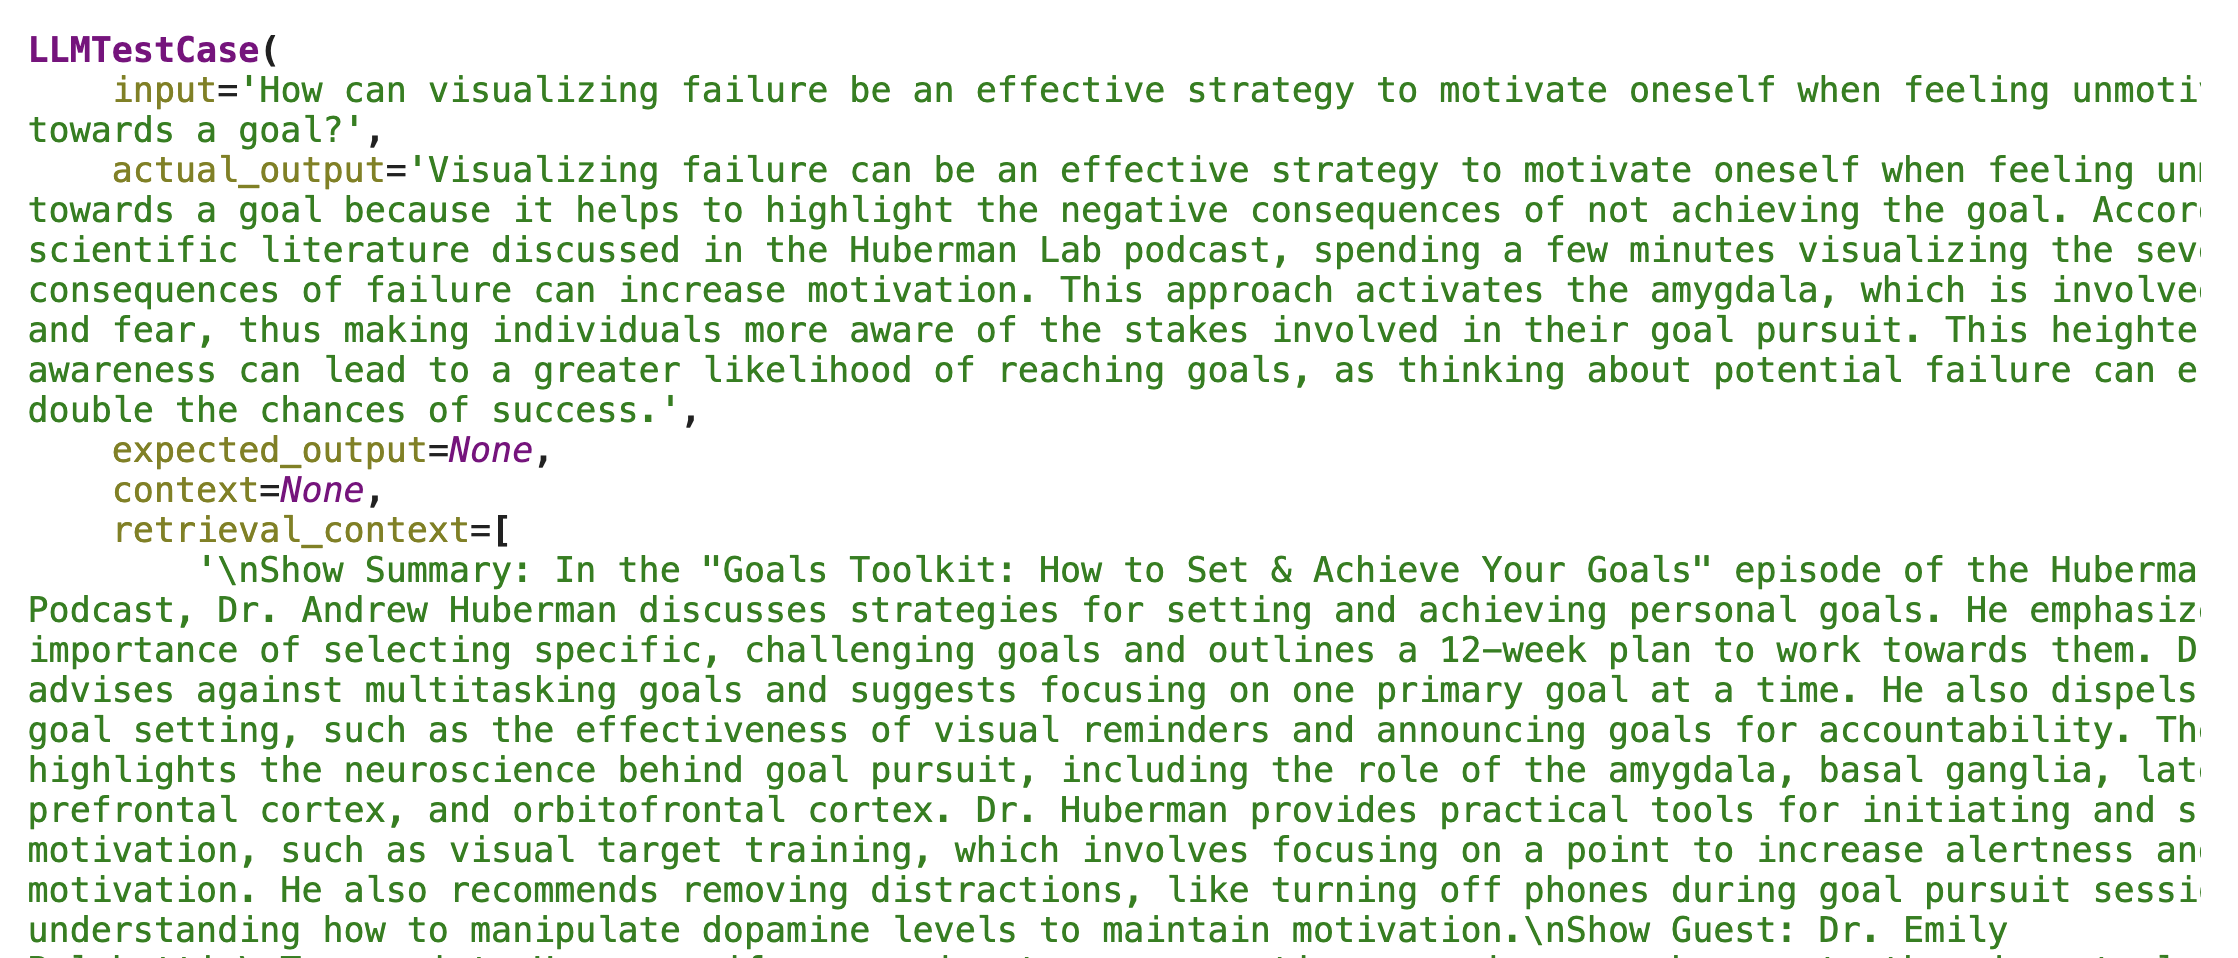
</details>

### 2a. Define Generation Evaluation function

In [73]:
from src.data_models import GenerationEvaluation
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric, load_eval_response
from notebook_helpers import get_model_name, get_model_cost

from deepeval.models.base_model import DeepEvalBaseLLM
from deepeval.test_case import LLMTestCase
from tqdm import tqdm
from deepeval import evaluate
    
def generation_evaluation(test_cases: list[LLMTestCase],
                          generation_config: dict,
                          evaluation_llm: str | DeepEvalBaseLLM = 'gpt-4o-mini',
                          eval_threshold: float=0.8,
                          context_chunk_size: int=256,
                          context_chunk_overlap: int=0
                          ) -> GenerationEvaluation:
    '''
    Execute bulk evaluation of test cases with a defined metric.
    '''
    generation_eval = GenerationEvaluation(**generation_config,
                                           eval_model=get_model_name(evaluation_llm),
                                           context_chunk_size=context_chunk_size,
                                           context_chunk_overlap=context_chunk_overlap,
                                           small_to_big=False)
    
    #################
    ##  START CODE ##
    #################

    evaluations = []
    for test_case in tqdm(test_cases):
        ac_metric = AnswerCorrectnessMetric(evaluation_llm, threshold=eval_threshold)
        ac_metric.measure(test_case, _show_indicator=False)
        evaluations.append(ac_metric)
    
    #################
    ##  END CODE   ##
    #################

    # parse metric responses into a list of EvalResponse objects
    eval_responses = [load_eval_response(response, data, return_context_data=False) for \
                      response, data in zip(evaluations, test_cases)]
    
    scores = [r.score for r in eval_responses]
    # if using an OpenAI model cost will be a float value, otherwise it will be 'N/A'
    cost = get_model_cost(eval_responses)

    #calculate and assign eval score values to generation_eval object
    generation_eval.eval_score = round(sum(scores)/len(scores),3)
    generation_eval.total_questions = len(scores)
    generation_eval.correct_answers = sum([score >= ac_metric.threshold for score in scores])
    generation_eval.incorrect_answers = generation_eval.total_questions - generation_eval.correct_answers
    
    return {'generation_eval': generation_eval, 'responses': eval_responses, 'scores': scores, 'cost': cost}

### Generation Configuration
You may have noticed when creating your `RAGPipeline` Class earlier in the notebook that there was a `generation_config` attribute.  This config is a way to pass along the reader LLM hyperparameters into your evaluation function.  As discussed throughout this course, the majority of these hyperparameters affect the amount of context that the reader LLM will have available to it during the answer synthesis step of your RAG Pipeline.  These are the knobs and dials that you can tweak to change your generation evaluation score. In the configuration example below you'll note that the `system` and `user` messages are themselves considered generation hyperparameters because they, of course, contribute greatly to the reader LLM output.  Likewise the reader LLM is itself a hyperparameter, given that different models will perform better or worse depending on the task. `generation_config` is a parameter for the `generation_evaluation` function.

<details>
    <summary><strong>Click to see Example Configuration</strong></summary>

```
{
    'reader_model': 'gpt-4o-mini',
    'temperature': 0.5,
    'verbosity': 'concisely',
    'num_context_chunks': 3,
    'system_message': 'You are a repository of knowledge and wisdom about the Huberman Lab podcast.\nThe Huberman Lab podcast is hosted by Dr. Andrew Huberman, a neuroscientist and tenured professor of neurobiology and ophthalmology at Stanford School of Medicine. The podcast discusses neuroscience and science-based tools, including how our brain and its connections with the organs of our body control our perceptions, our behaviors, and our health, as well as existing and emerging tools for measuring and changing how our nervous system works. The podcast is frequently ranked in the top 10 of all podcasts globally and is often ranked #1 in the categories of Science, Education, and Health & Fitness.\nYour task is to answer questions about the Huberman Lab podcast only using the context provided in the user message.\nOnly use the context provided to answer the question. Do not use any external knowledge or resources to answer the question.',
    'user_message': 'Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his guest(s).\nAfter your synthesis, use the series of transcripts to answer the below question.  The series will be in the following format:\n\n```\nShow Summary: <summary>\nShow Guest: <guest>\nTranscript: <transcript>\n```\n\nStart 
Series:\n```\n{series}\n```\nQuestion:\n\n{question}\n\n------------------------\n1. If the context does not provide enough information to answer the question, then\nstate that you cannot answer the question with the provided context.\n2. Do not use any external knowledge or resources to answer the question.\n3. Answer the question directly and {verbosity}.\n------------------------\nAnswer:}
```
</details>

### 2b. Execute `generation_evaluation`   

In [74]:
from notebook_helpers import record_project2_submission

#################
##  START CODE ##
#################

#execute evaluation
response_dict = generation_evaluation(llm_test_cases, pipe.generation_config)

#################
##  END CODE   ##
#################

# Do NOT touch these lines of code 
generation_eval = response_dict['generation_eval']
record_project2_submission(generation_eval)

  0%|          | 0/20 [00:00<?, ?it/s]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


  5%|▌         | 1/20 [00:01<00:23,  1.24s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 10%|█         | 2/20 [00:03<00:30,  1.71s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 15%|█▌        | 3/20 [00:05<00:33,  1.96s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 20%|██        | 4/20 [00:07<00:28,  1.79s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 25%|██▌       | 5/20 [00:08<00:26,  1.75s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 30%|███       | 6/20 [00:10<00:22,  1.63s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 40%|████      | 8/20 [00:14<00:22,  1.86s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 45%|████▌     | 9/20 [00:16<00:21,  1.98s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 50%|█████     | 10/20 [00:18<00:18,  1.89s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 55%|█████▌    | 11/20 [00:19<00:16,  1.79s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 60%|██████    | 12/20 [00:21<00:13,  1.66s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 65%|██████▌   | 13/20 [00:22<00:11,  1.61s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 70%|███████   | 14/20 [00:24<00:09,  1.59s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 75%|███████▌  | 15/20 [00:25<00:07,  1.52s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 80%|████████  | 16/20 [00:27<00:06,  1.58s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 85%|████████▌ | 17/20 [00:28<00:04,  1.58s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


/usr/local/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=112 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/usr/local/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=83 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/usr/local/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=84 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/usr/local/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=85 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)
/usr/local/lib/python3.10/asyncio/selector_events.py:710: ResourceWarning: 

Event loop is already running. Applying nest_asyncio patch to allow async execution...


 95%|█████████▌| 19/20 [00:32<00:01,  1.66s/it]

Event loop is already running. Applying nest_asyncio patch to allow async execution...


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]
2024-12-11 16:19:44.790 | INFO     | src.preprocessor.preprocessing:save_as_json:109 - Data saved as json file here: ./eval_results/generation_eval_2024-12-11-16-19-44.json


In [75]:
# view generation evaluation output
print(generation_eval)

GenerationEvaluation(
    eval_model='gpt-4o-mini',
    reader_model='gpt-4o-mini',
    temperature=0.5,
    num_context_chunks=3,
    verbosity='concisely',
    context_chunk_size=256,
    context_chunk_overlap=0,
    small_to_big=False,
    system_message='\nYou are a repository of knowledge and wisdom about the Huberman Lab podcast.\nThe Huberman 
Lab podcast is hosted by Dr. Andrew Huberman, a neuroscientist and tenured professor of neurobiology \nand 
ophthalmology at Stanford School of Medicine. The podcast discusses neuroscience and science-based tools, 
\nincluding how our brain and its connections with the organs of our body control our perceptions, our behaviors, 
\nand our health, as well as existing and emerging tools for measuring and changing how our nervous system works. 
\nThe podcast is frequently ranked in the top 10 of all podcasts globally and is often ranked #1 in the categories 
\nof Science, Education, and Health & Fitness.\nYour task is to answer questions about the Huberman Lab podcast 
only using the context provided in the user message.\nOnly use the context provided to answer the question. Do not 
use any external knowledge or resources to answer the question.\n',
    user_message='\nYour task is to synthesize and reason over a series of transcripts of an interview between 
Andrew Huberman and his guest(s).\nAfter your synthesis, use the series of transcripts to answer the below 
question.  The series will be in the following format:\n\n```\nShow Summary: <summary>\nShow Guest: 
<guest>\nTranscript: <transcript>\n```\n\nStart 
Series:\n```\n{series}\n```\nQuestion:\n\n{question}\n\n------------------------\n1. If the context does not 
provide enough information to answer the question, then\nstate that you cannot answer the question with the 
provided context.\n2. Do not use any external knowledge or resources to answer the question.\n3. Answer the 
question directly and {verbosity}.\n------------------------\nAnswer:\n',
    total_questions=20,
    correct_answers=20,
    incorrect_answers=0,
    eval_score=0.993
)

# Conclusion
***

We now have a way of measuring the performance of the **Generation** component of our RAG system.  This will allow you to make tweaks/changes to the system and then be able to objectively tell whether or not the tweak/change improved or degraded its performance.  Here are a few things to consider going forward:  
- The easiest parameters to tweak are the `num_context_chunks`, `verbosity` and the model `temperature`.  Try giving the model more context to see if that improves or worsens your evaluation score.
- The `small_to_big` parameter is soemthing we will explore in notebook 7.  You'll see that implementing small-to-big retrieval allows us to retrieval at a more granular level, but present the reader LLM with a larger context window for answer synthesis.
- You could also change your reader model from `gpt-4o-mini` to another OpenAI model and see how it does.  For the adventurous, feel free to use another LLM from an entirely different LLM provider i.e. Anthropic or even an open source variant.  --> You'll likel need to tweak the code to support an Open Source LLM. 
- To get a real feel for how well your system is peforming I recommend trying out the Optional section below where you generate new Test Cases (randomly) and then run a new evaluation.  I recommend generating at least 30 test cases.
---
### \** BREAK ** To go futher in-depth see additional Optional sections below \** BREAK **
---

# *** Optional: Using Custom Evaluation LLMs ***

`DeepEval` provides a way to use evaluation LLMs other than OpenAI models.  Just know that if you do so, cost information is not supported with other models at this time.  CustomClass wrappers have already been written for this course that support Anthropic and Cohere models.  To use them see code examples below. Loading these models assumes you have the following environment variables set:  

**Anthropic**
- `ANTHROPIC_API_KEY`
  
**Cohere**
- `COHERE_API_KEY`

Using a different LLM for evaluation other than an OpenAI model will reveal some interesting differences between the way that other LLMs assess input.  Personally, I have noticed a bias in models from the same LLM provider favoring output from their same model class i.e. `gpt-4o` favoring `gpt-4o-mini` output.  You can draw your own conclusions if you conduct this exercise. 

In [ ]:
from src.evaluation.llm_evaluation import CustomAnthropic, CustomCohere
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric

print(CustomAnthropic.accepted_model_types)
print(CustomCohere.accepted_model_types)

In [ ]:
#instantiate Custom DeepEval LLMs like so
sonnet = CustomAnthropic('claude-3-sonnet-20240229')
command_plus = CustomCohere('command-r-plus')

# the custom model can then be passed as the evaluation_model arg to AnswerCorrectnessMetric 
# to use with evaluations
ac_metric = AnswerCorrectnessMetric(evaluation_model=sonnet)

# Run the below line if you want to execute the full evaluation that you did in Assignment 2.4
# response_dict = generation_evaluation(llm_test_cases, pipe.generation_config, evaluation_llm=sonnet)

<details>
    <summary>Click to see my baseline results from Anthropic's Opus model.</summary>

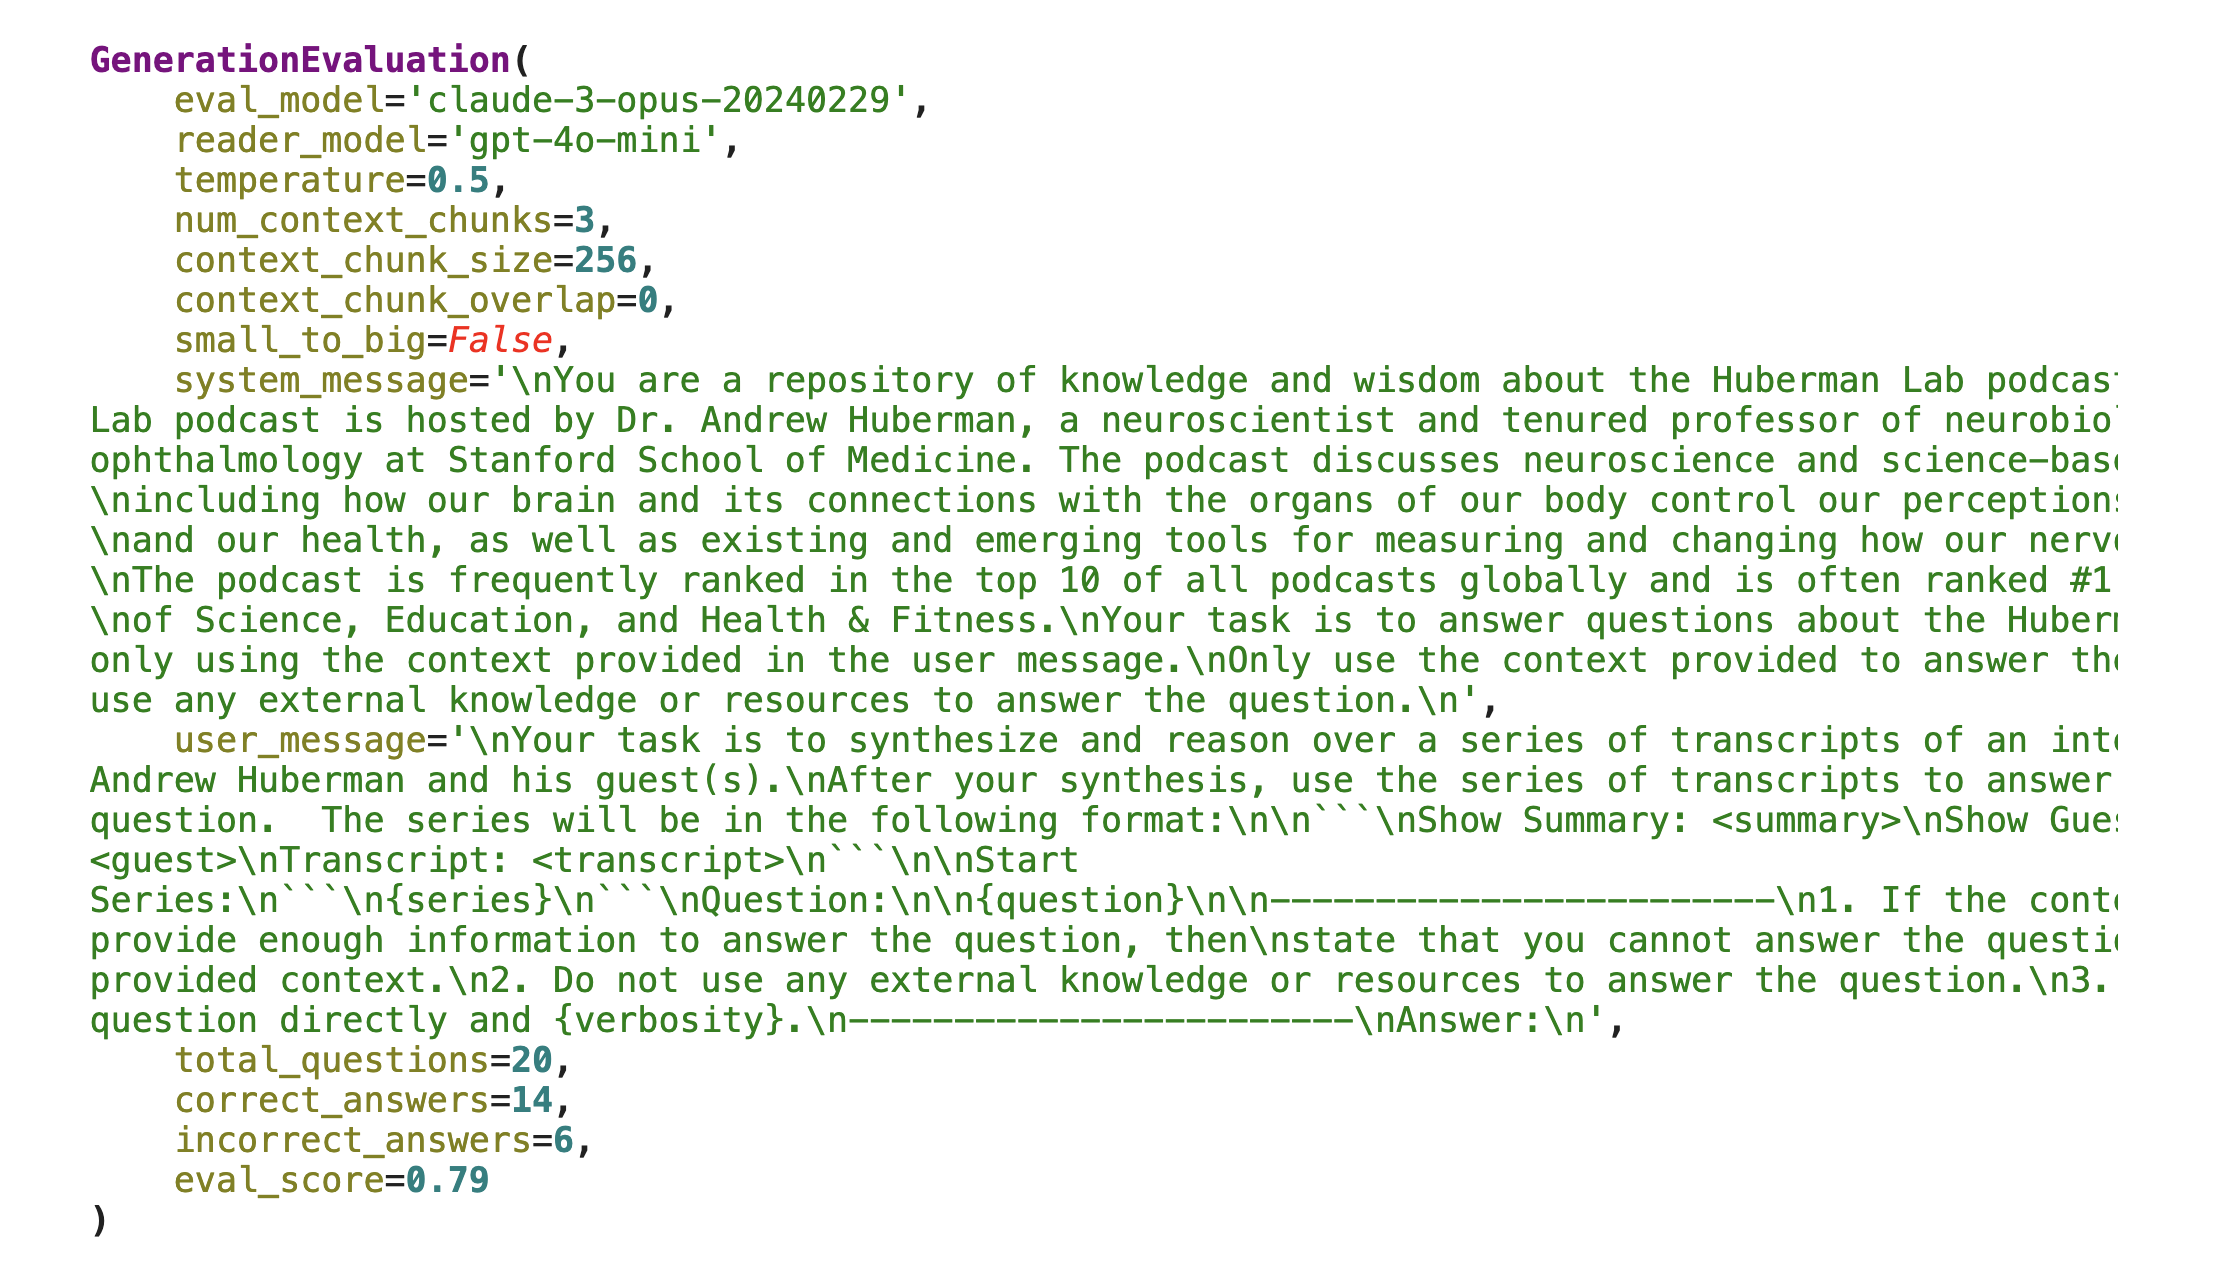 

#### It appears that compared with OpenAI gpt-4o from above, Opus is a much harder grader on `gpt-4o-mini` than `gpt-4o`...surprised?  🤡
</details>

# *** Optional: Generating your own Test Cases ***

If you'd like to quickly generate your own Test Cases, I have included a function which will asynchronously make LLM calls to speed up the process. If you plan on using this function, make sure that your LLM Provider Rate Limit will support the amount of Test Cases you want to generate, or submit your calls in fewer batches to avoid the 429 Rate Limit Error.  This is a sample implementation only, but feel free to change the code [in this file:](https://github.com/americanthinker/rag-applications/blob/main/src/evaluation/llm_evaluation.py#L227) `rag-applications/src/evaluation/llm_evaluation.py` if you want to use this functionality as part of your actual LLM evaluations.  

### Set Components

In [138]:
llm = LLM('gpt-4o-mini')
retriever = WeaviateWCS(os.environ['WEAVIATE_ENDPOINT'], os.environ['WEAVIATE_API_KEY'], skip_init_checks=True)
reranker = ReRanker()

In [139]:
#instantiate the TestCaseGenerator
from src.evaluation.llm_evaluation import TestCaseGenerator

tcg = TestCaseGenerator(llm, retriever, reranker)

### Get Queries
The data needed to generate test cases is a list of queries.  You can either generate these manually or use an LLM to generate them for you.  In this example, I am grabbing the queries from one of the available golden datasets.  

In [140]:
from src.preprocessor.preprocessing import FileIO

data_path = '../data/golden_datasets/golden_512.json'
data = FileIO.load_json(data_path)
queries = list(data['queries'].values())
print(queries[:5])
print(f'Total of {len(queries)} queries.')

[
    'How does Athletic Greens (AG1) help ensure the intake of essential vitamins and minerals?',
    "How do non-human primates' neural connections differ in terms of controlling facial expressions and 
vocalizations?",
    "How does listening to music activate the brain's prediction machinery and circuits responsible for registering
novelty?",
    'What can impact the course of treatment for patients experiencing pain?',
    'How is working memory related to attention?'
]

Total of 100 queries.

In [141]:
# 1. decide how many test cases you want to create
# 2. randomize the data to test generalization of your system

from random import shuffle

shuffle(queries)
thirty_queries = queries[:30]
print(thirty_queries)

[
    'How can listeners support the Huberman Lab podcast?',
    'How was the coordination of menstrual cycles among co-housed women described in the early literature?',
    'How does the gut communicate with the brain in terms of both chemical and mechanical signaling?',
    'How can alpha-GPC combined with low levels of caffeine potentially improve skill learning?',
    'What are some benefits of yerba mate that are discussed in the podcast?',
    'How does social media influence the feeling of social interaction in the context of social homeostasis?',
    'How can incorporating the physiological sigh between sets of exercise improve fitness and recovery?',
    'How can healthcare systems create a structure to efficiently include interdisciplinary teams for integrative 
care?',
    'How does sleep, particularly during the early stage of infection, contribute to enhancing the immune system?',
    'How do compounds such as Adderall and Ritalin help children with ADHD?',
    'How is dopamine associated with the experience of reward and movement?',
    'What neurotransmitter is involved in learning and plasticity during the sleep spindle stage of sleep?',
    'What dimension of social interaction in the context of social homeostasis is highlighted in the analogy with 
caloric intake?',
    "What brain region acts as a thermostat for the body's internal core temperature, and how does it respond to 
the application of a cold surface to the body?",
    "What is the most abundant semi-volatile in baby hints according to the lab's findings?",
    'How does the immune system respond to cells infected with viruses and undergoing damage?',
    'How can delaying caffeine intake help with compensatory sleep after staying up late?',
    'How does the body physiologically prepare for penetration during sexual arousal?',
    'How can you achieve long-lasting increases in baseline dopamine levels using L-tyrosine?',
    'What topics are covered on the Huberman Lab social media platforms?',
    'What did the study on light exposure and mental health outcomes reveal about the impact of nighttime dark 
exposure?',
    'How can a meditation practice be tailored to focus on external stimuli or interoceptive awareness based on the
breathing pattern used?',
    'How did the study explore the impact of meal timing on muscle hypertrophy in mice and humans?',
    'Why does testosterone not increase aggressiveness according to the conversation with Robert Sapolsky?',
    'What role does non-sleep deep rest and nutrition play in maintaining a sufficient level of baseline 
dopamine?',
    'How does high levels of zinc supplementation impact sperm count and testosterone levels in males?',
    'What molecule is thought to augment the activity of neural circuits related to the pleasure system and is 
associated with the ingestion of certain forms of dark chocolate?',
    'How can feedback about sleep affect cognitive performance regardless of the actual quality of sleep?',
    'How does the variability in mixed martial arts differ from other sports in terms of competition schedule and 
weight classification?',
    'What strategy should you avoid when trying to resolve a low baseline level of dopamine after a peak 
experience?'
]

#### Create Test Cases
Executing the `acreate_test_cases` function performs the following operations under the hood:
- Retrieves context for the queries submitted.
- Reranks them using the ReRanker
- Passes that context to the LLM to generate an answer to the query (this step is performed asynchronously)
- Loads all information, input, actual_output, and retrieval_context into a LLMTestCase bundle and returns a list of `LLMTestCases`

In [142]:
#import timer function to show how quick this can be when using async
from unitesting_utils import timer

with timer():
    generated_test_cases = await tcg.acreate_test_cases(thirty_queries, 'Huberman_minilm_256', 100)

LLM CALLS: 100%|██████████| 30/30 [00:04<00:00,  7.13it/s]
2024-12-11 14:37:13.849 | INFO     | unitesting_utils:timer:54 - 5.74 minutes


In [ ]:
generated_test_cases[0]